In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import random
import math

import pickle
import os

In [2]:
from simulator import AELayer
from common import spk_t, default_spike_eval, plot_spikes

def my_stdp(ref_time, run_time, curr_time, spike_to_value,
            t_minus, t_plus, weights, min_w, max_w, delta_w,
            learn_rate,
            last_pre_spikes, last_post_spikes, 
            pre_spikes, post_spikes, target_spikes):
    # post_input = [w]*pre_spikes
    w = weights

    # time weight <==> sooner spikes (t->ref) should be more important    
    tw = spike_to_value(ref_time, run_time, curr_time, 1.)
#     tw = 1.
    ww = learn_rate*tw
    tgt_rows = np.where( target_spikes > 0 )[0]
    hid_cols = None
    delta_w_pad = curr_time - t_plus
    twin_start = max(0, delta_w_pad)
    delta_w_pad = -delta_w_pad if delta_w_pad < 0 else 0

#                 left_bound = max(t-tau_stdp+1-delay, 0)

    if (post_spikes[:, t]>0).any() or (target_spikes[:, t]>0).any():

        # Look the spikes of hiden units for a time period of STDP window
        temp_deltaw = np.einsum('jk,k->jk', pre_spikes[:, twin_start:curr_time], delta_w[delta_w_pad:])

    # W-
        w -= np.sum(np.einsum('i,jk->ijk', post_spikes[:, t], temp_deltaw), axis=2)*ww #STDP
        w[post_spikes[:, t]>0, :] -= (ww*0.1) # weights decrease even without STDP
    # W+
        w += np.sum(np.einsum('i,jk->ijk', target_spikes[:, t], temp_deltaw), axis=2)*ww #STDP
        w[target_spikes[:, t]>0, :] += (ww*0.1) # weights increase even without STDP

    w[:] = np.clip(w, min_w, max_w)

    return w

In [3]:
np.random.seed(10)
# www = np.arange(3*2).reshape((3, 2))
# www.T[1, :] = 333
# print(www)
# #network configuraiton
# v_size = 21
# h_size = 50



In [4]:
# import mnist_utils as mu
# train_x, train_y = mu.get_train_data()
# train_x /= 255. # <- wouldn't this make it [0., 1.]?
in_size = 3#794
hid_size = 5#500
run_time = 50
delay = 0
tgt_delay = 15
description = {'level': 0,
               'run_time': run_time,
               'sizes': {'in': in_size, 'hid': hid_size, 'rcn': in_size},
               'delays': {'in': delay*np.ones(in_size),
                          'hid': delay*np.ones(hid_size),
                          'rcn': delay*np.ones(in_size)},
               'in_times': np.zeros((in_size, 1)),
               'neuron_params': {'v_thresh': 1.,   # membrane potential threshold
                                 'v_rest':   0.,     # resting potential
                                 'tau_m':    20.,},
               'stdp': {'func':       my_stdp,
                        'max_w':      0.5,
                        'min_w':     -0.5,
                        't_plus':     20.,
                        't_minus':    20.,
                        'learn_rate': 0.005,
                        'target_times': np.zeros((in_size, 1), dtype=np.int32),
                        'target_delay': tgt_delay,},
              }



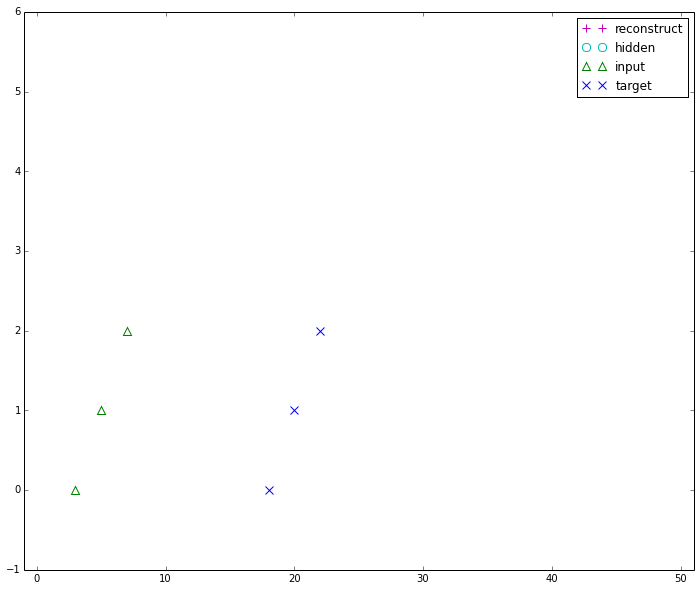

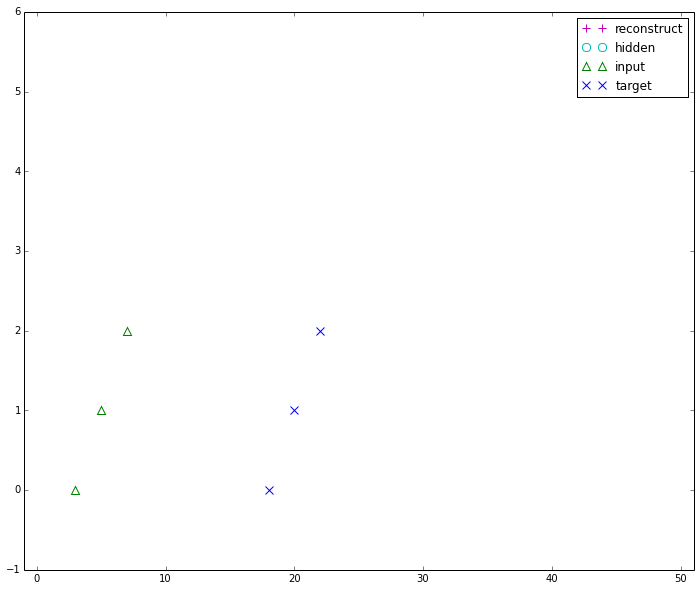

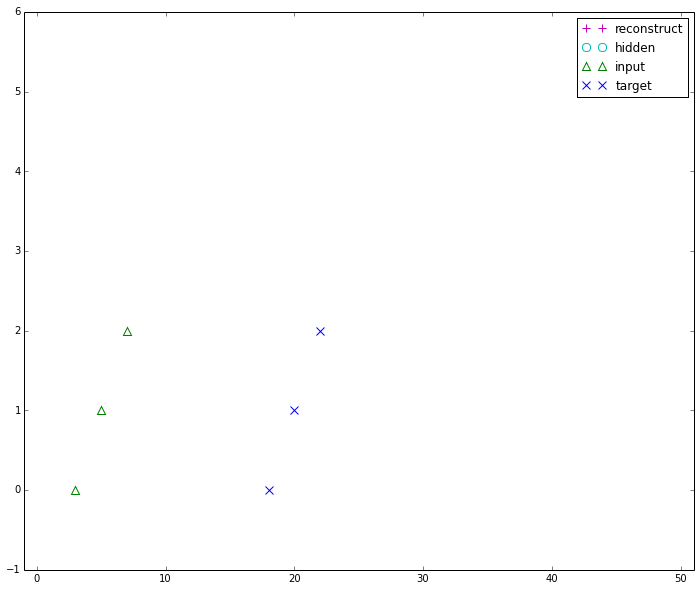

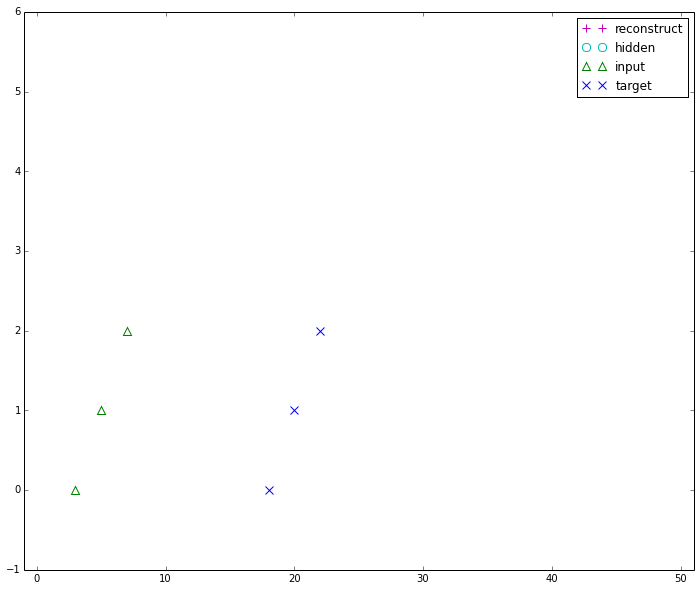

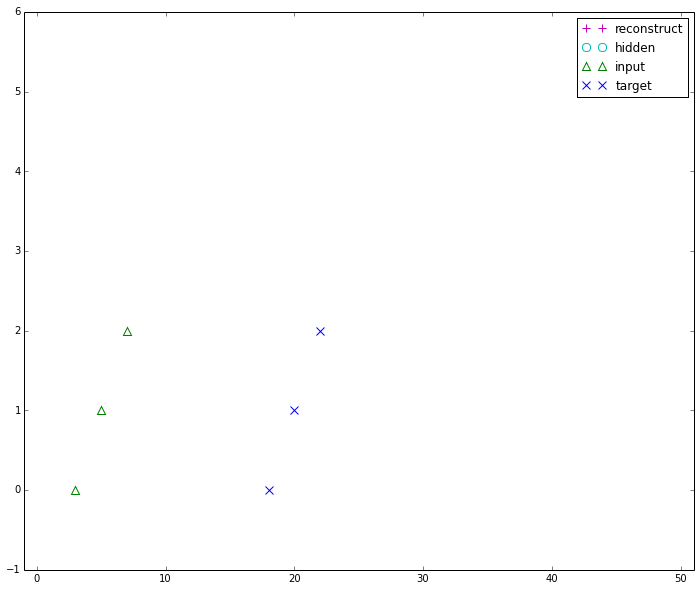

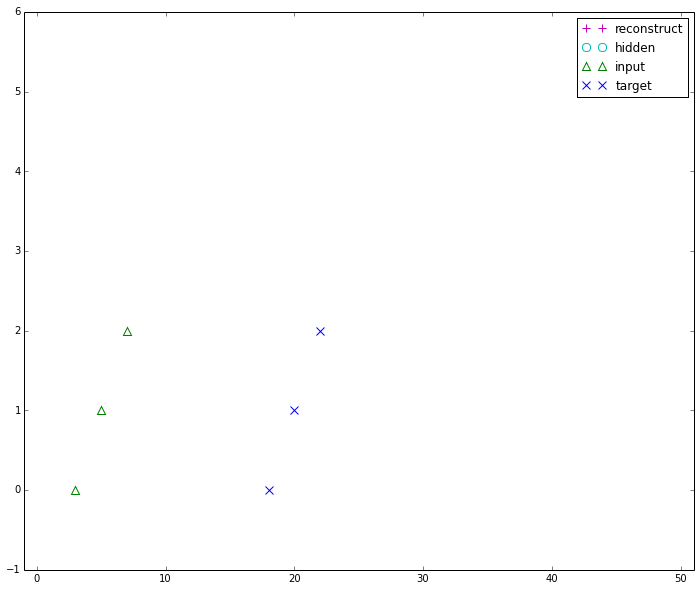

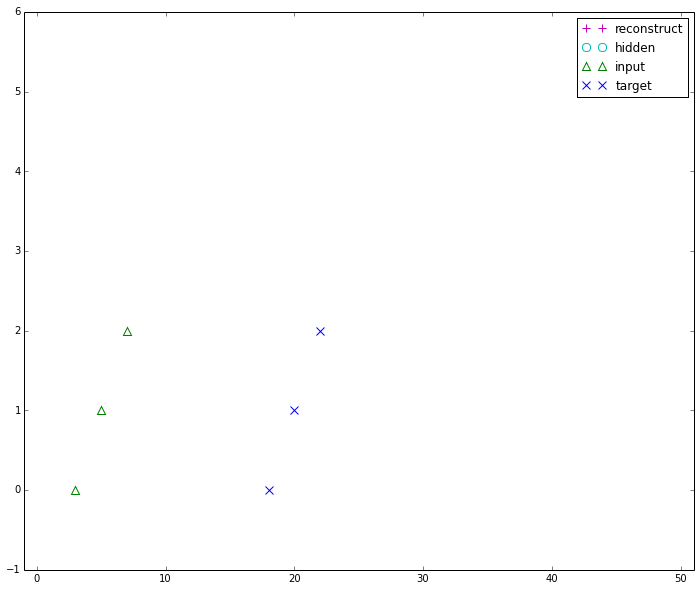

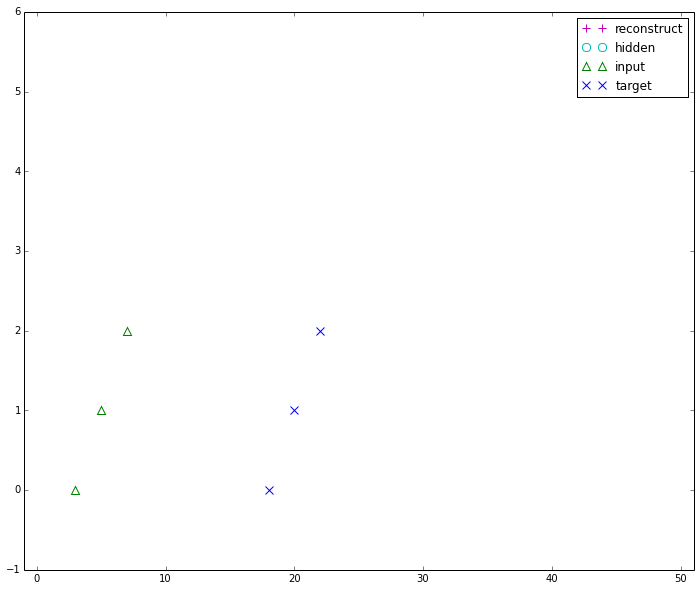

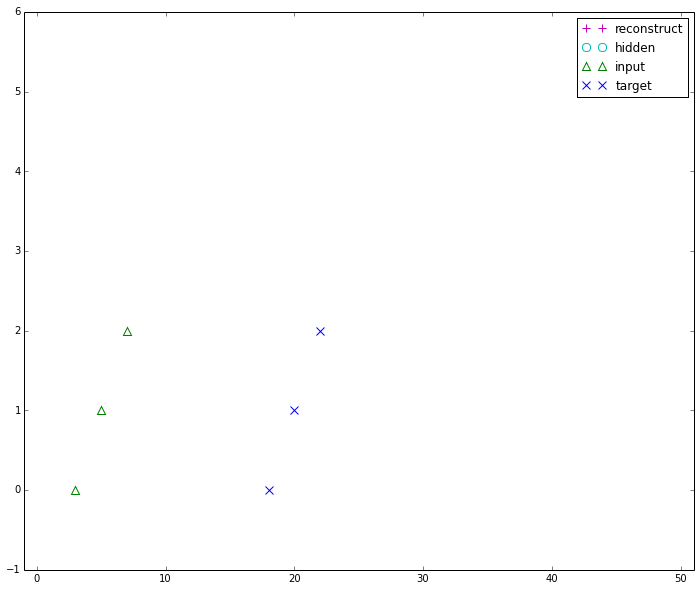

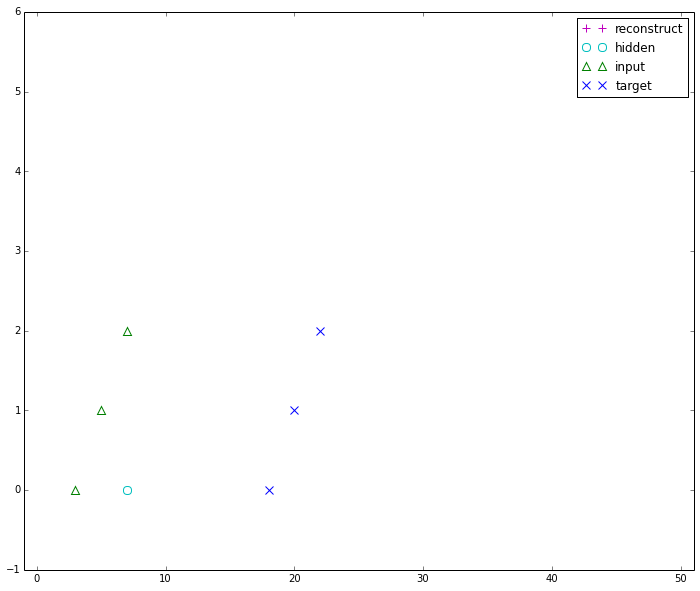

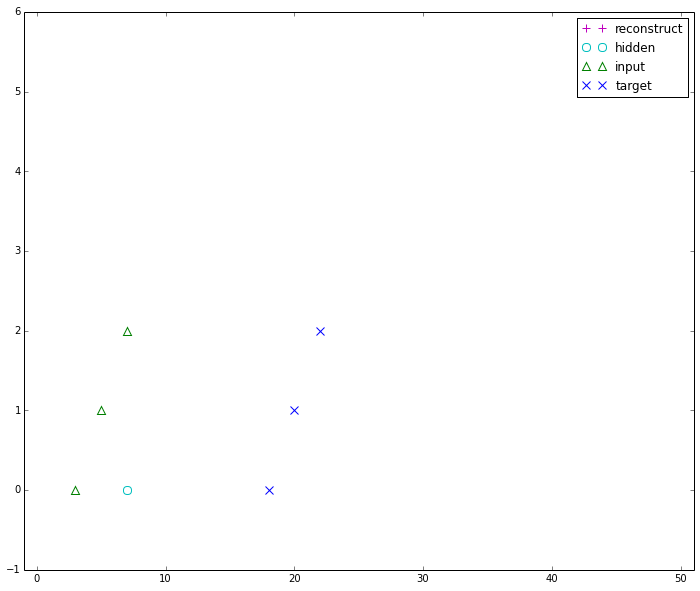

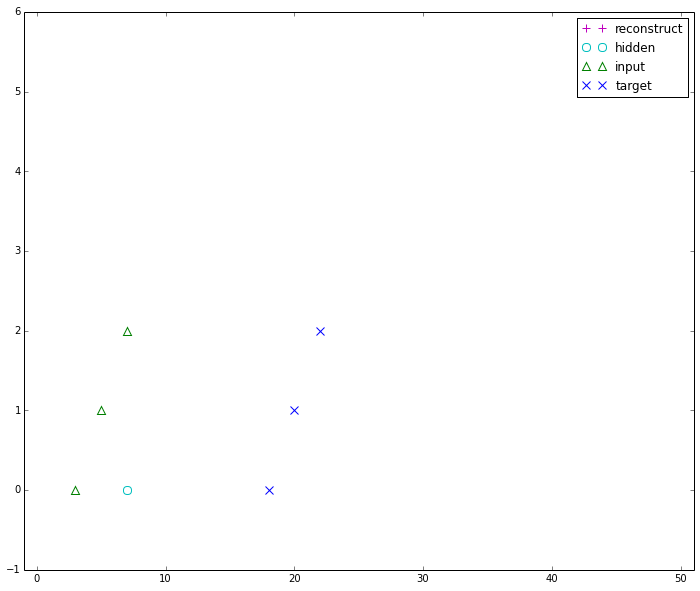

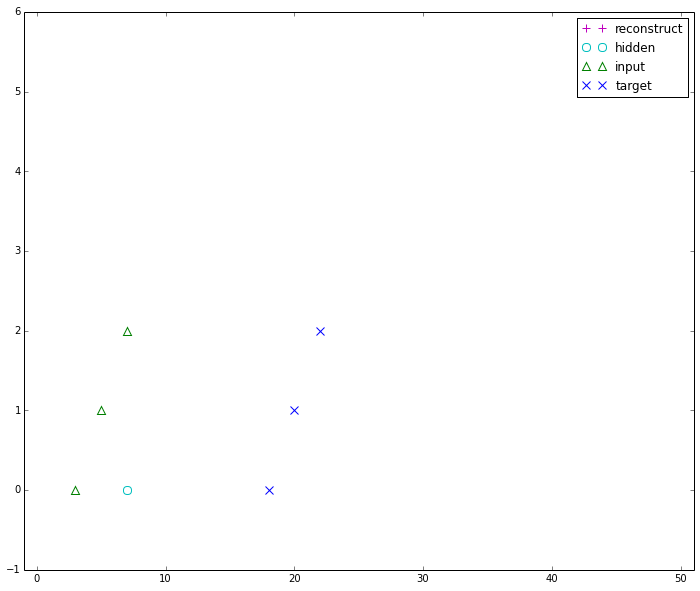

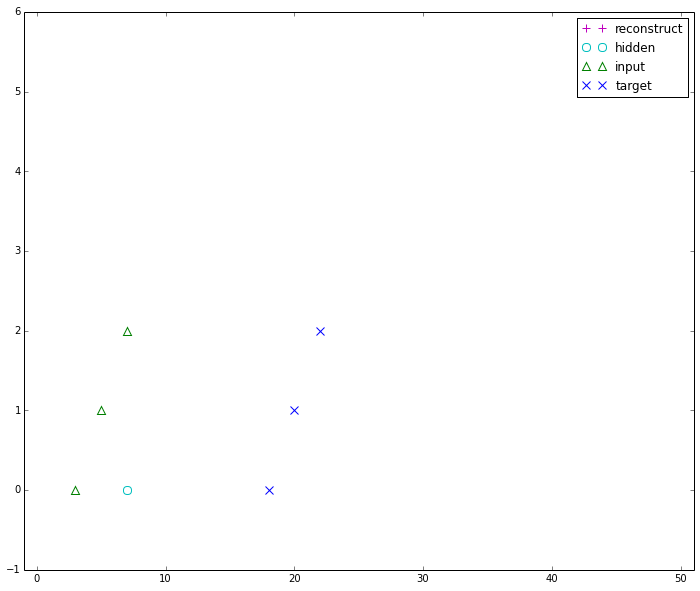

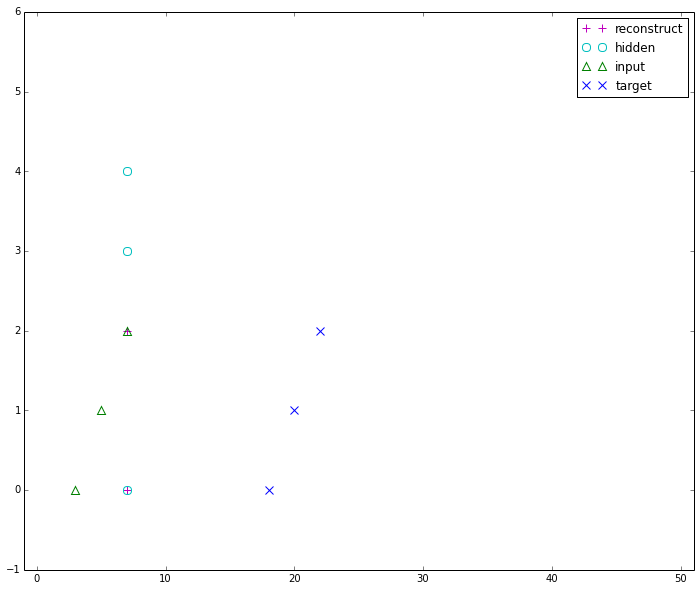

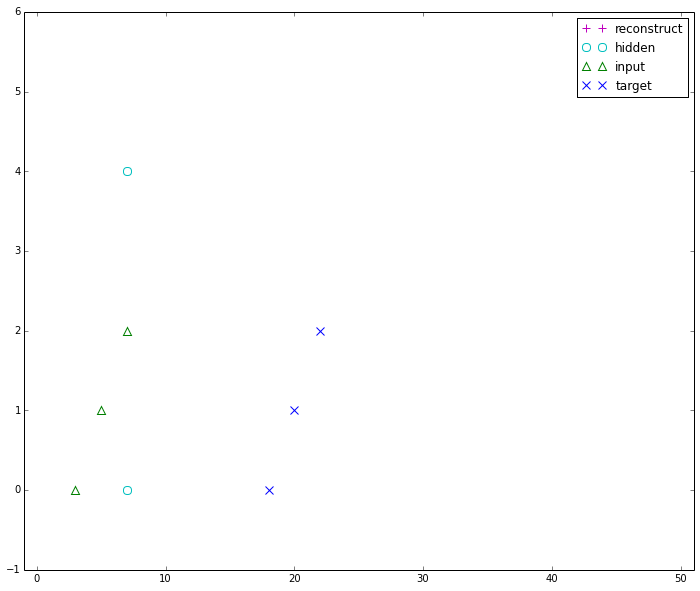

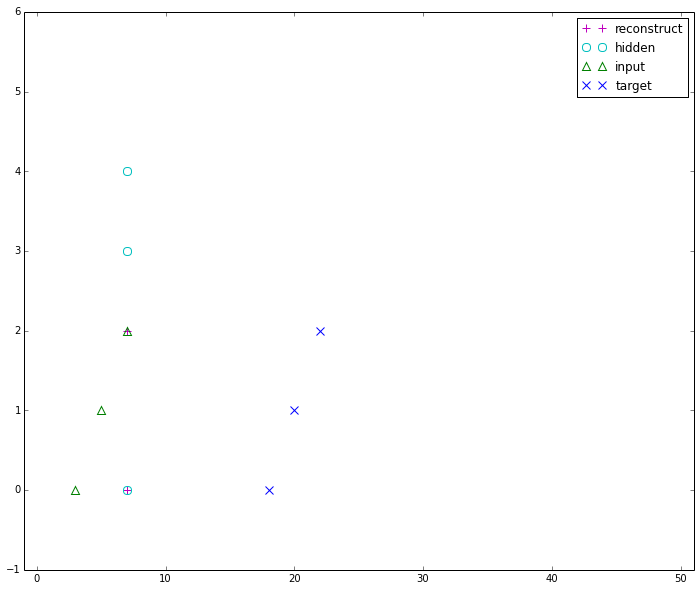

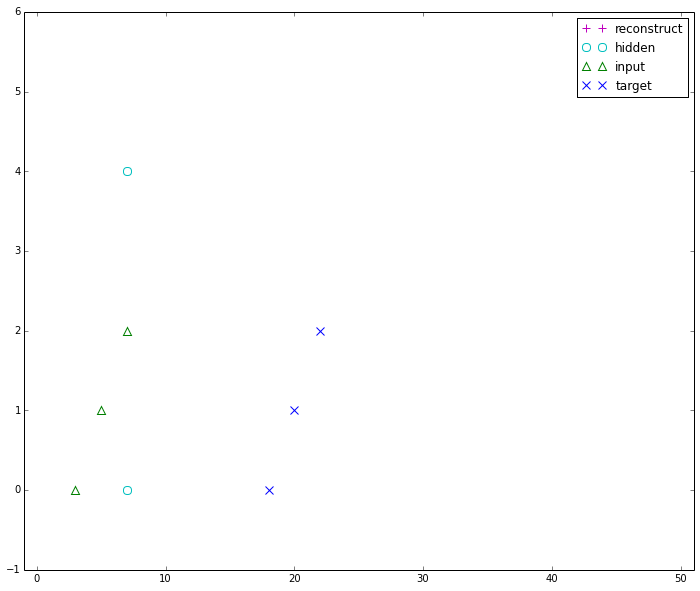

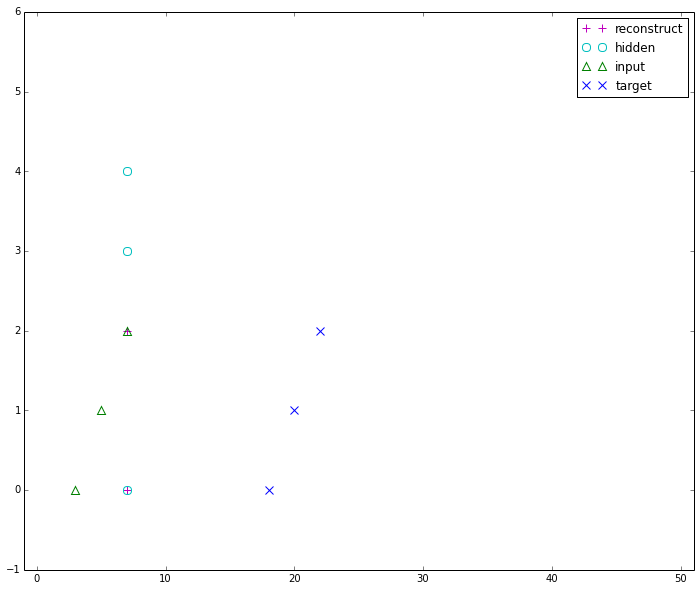

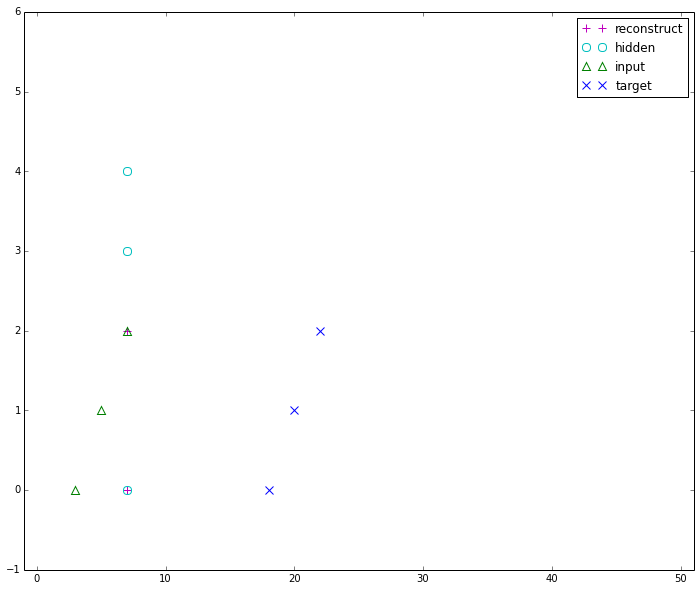

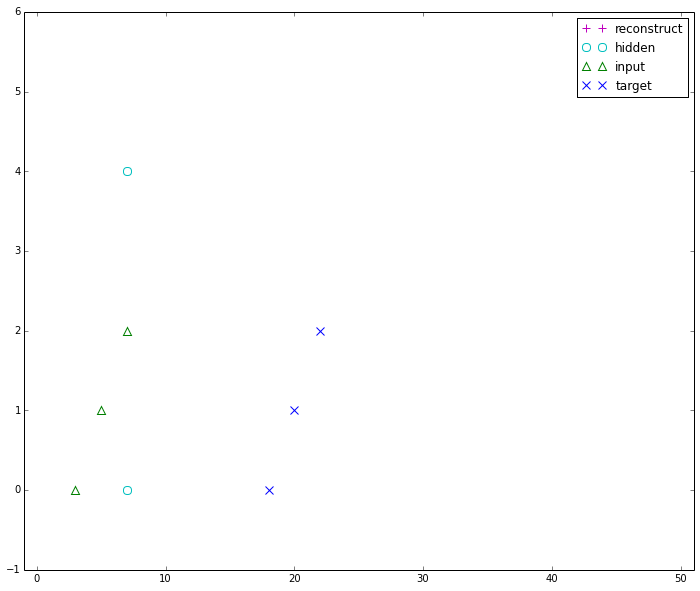

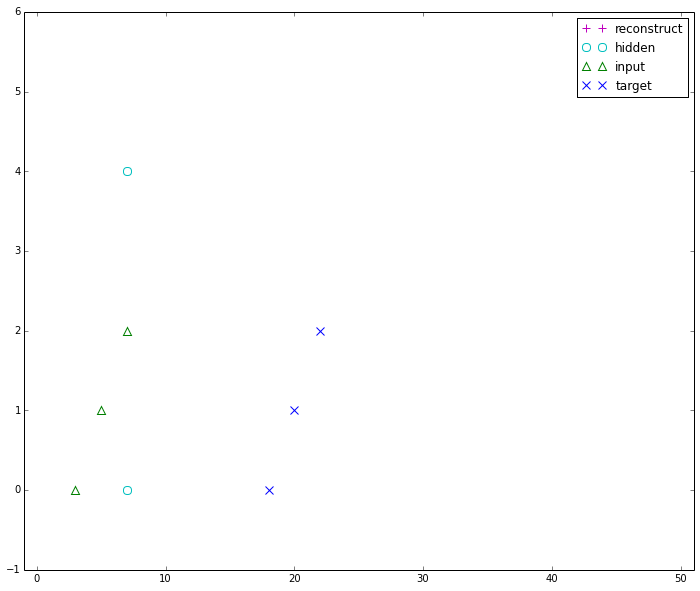

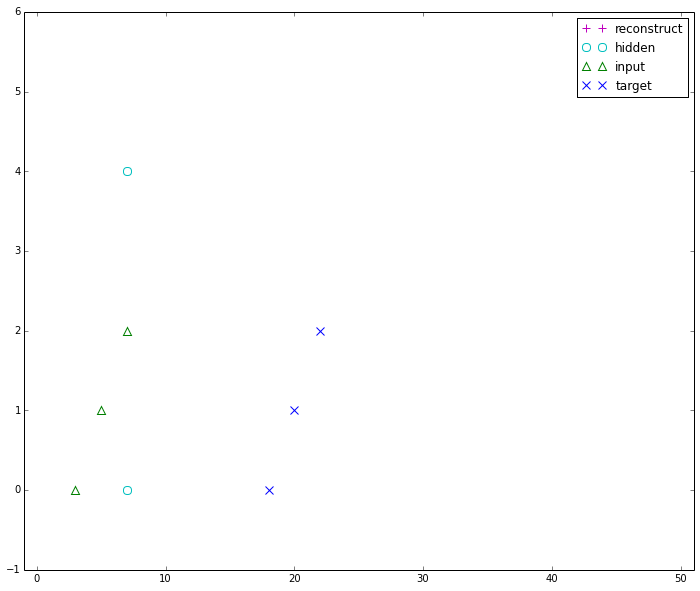

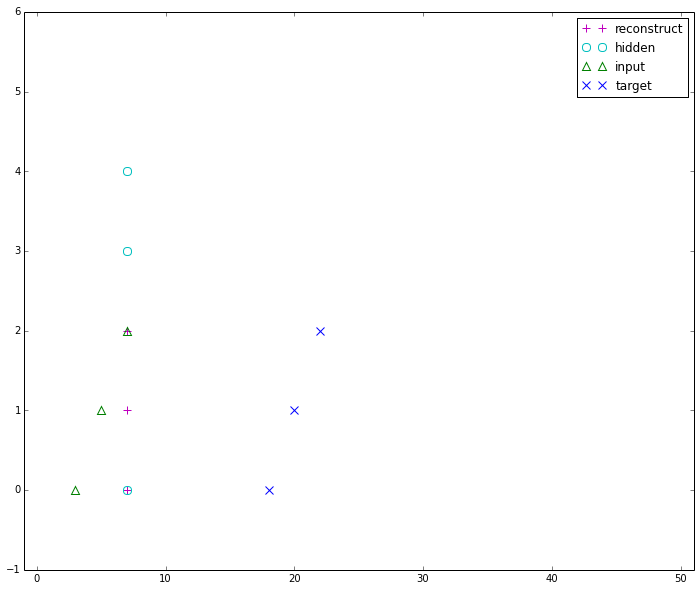

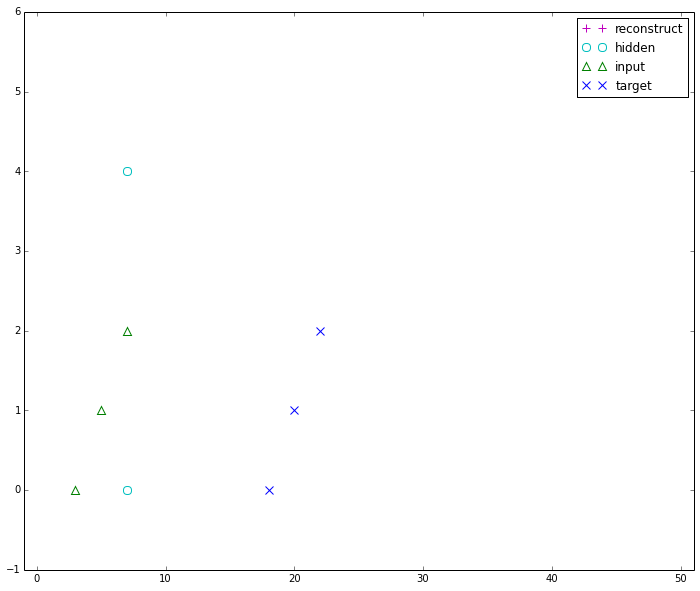

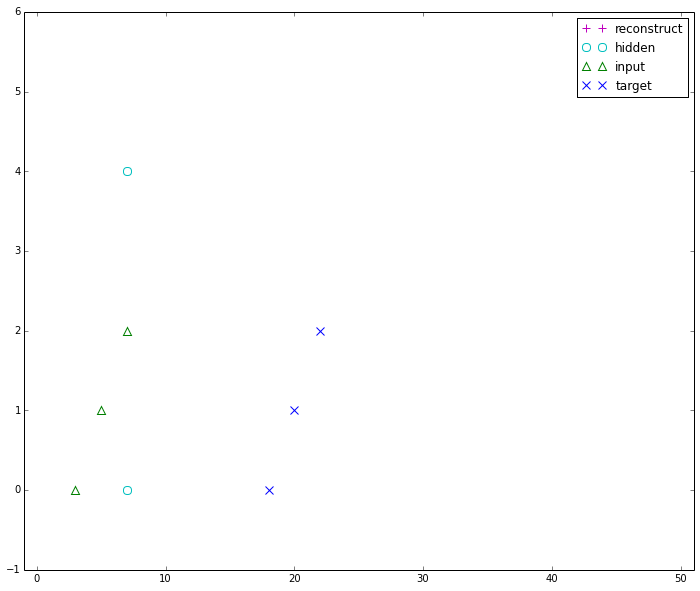

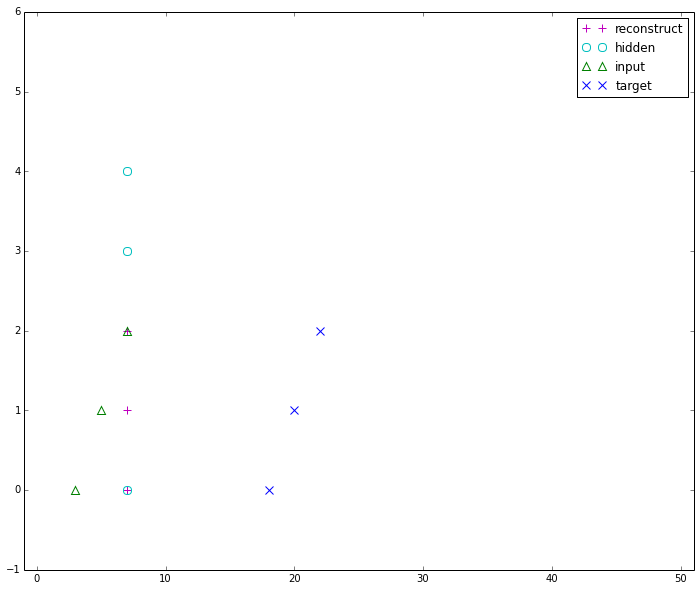

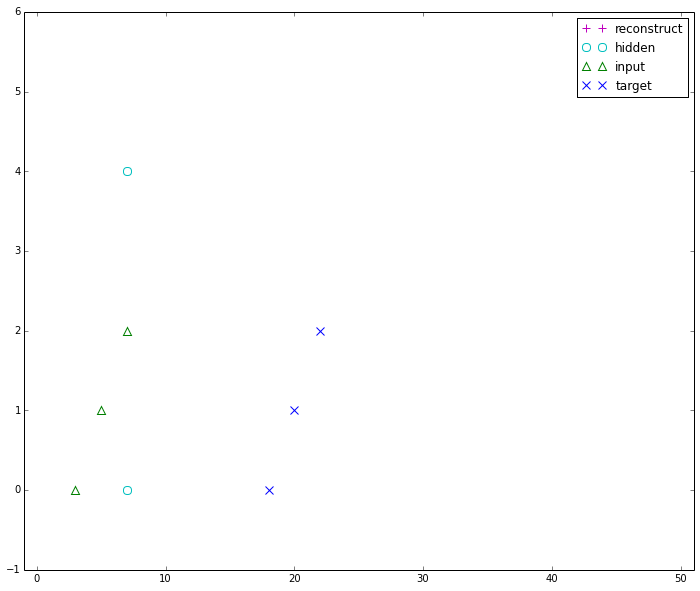

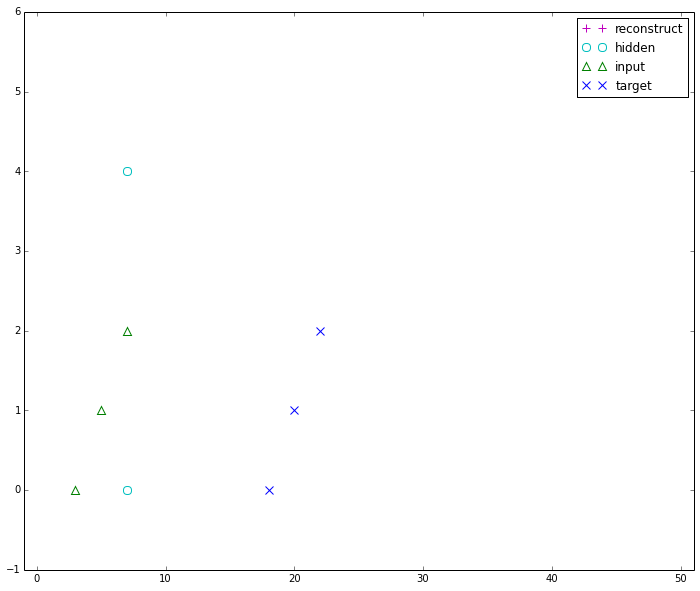

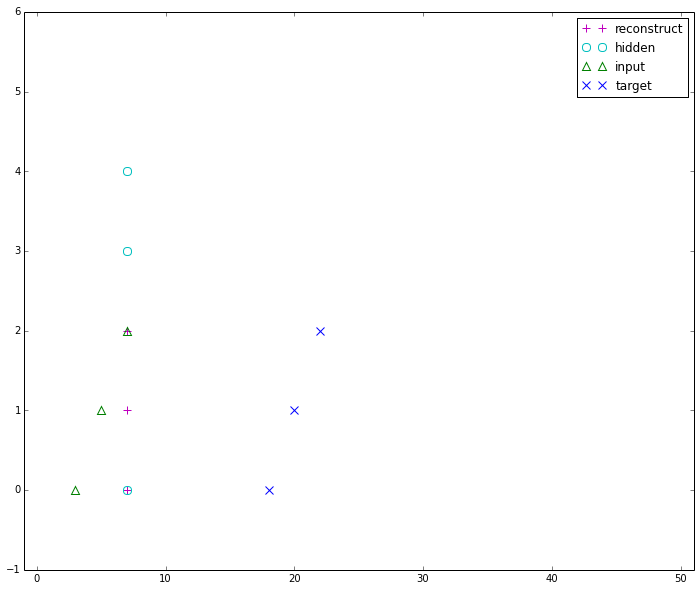

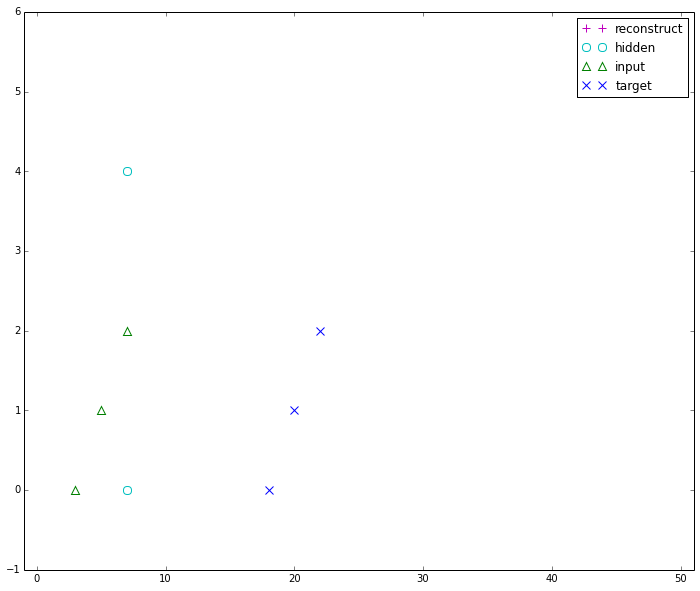

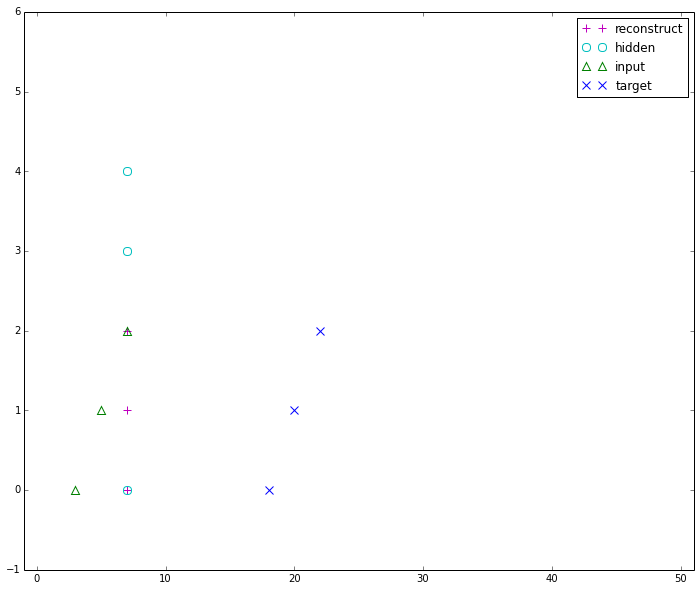

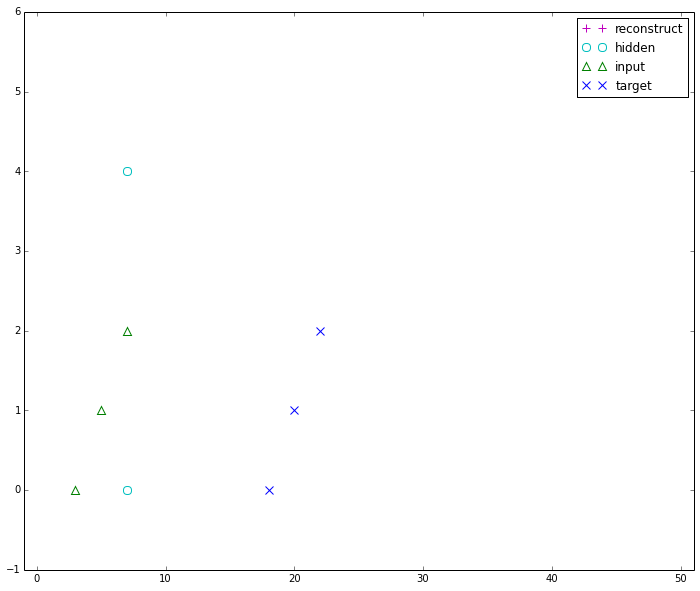

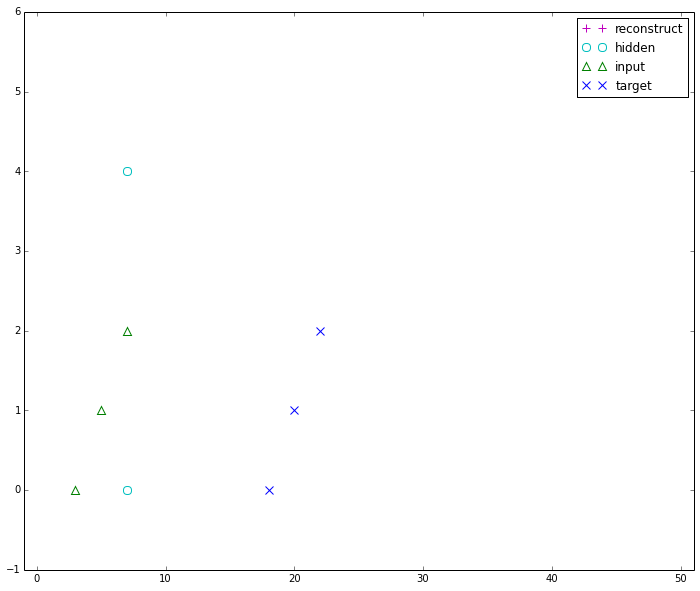

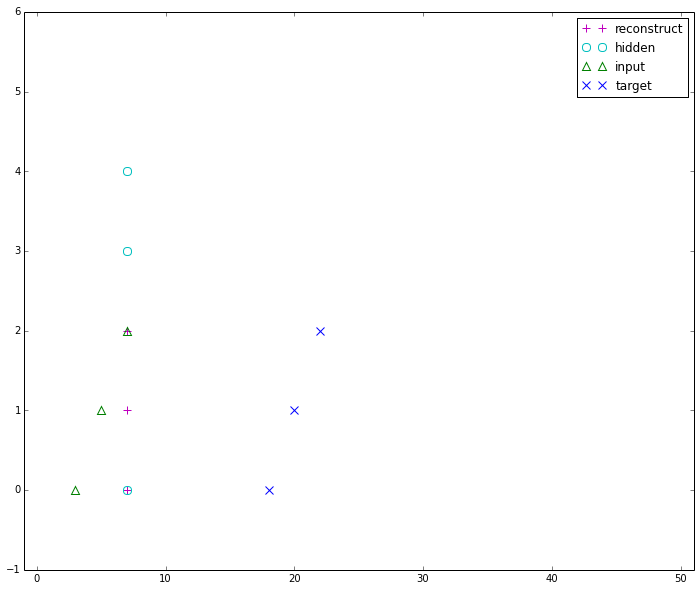

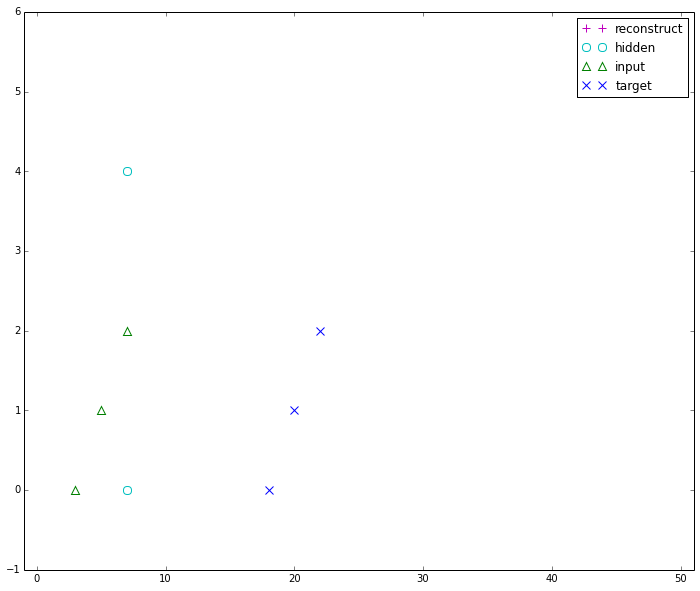

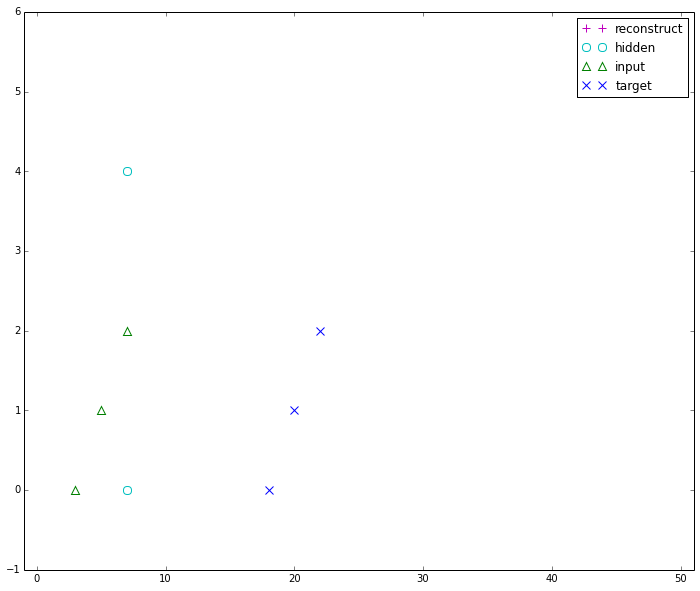

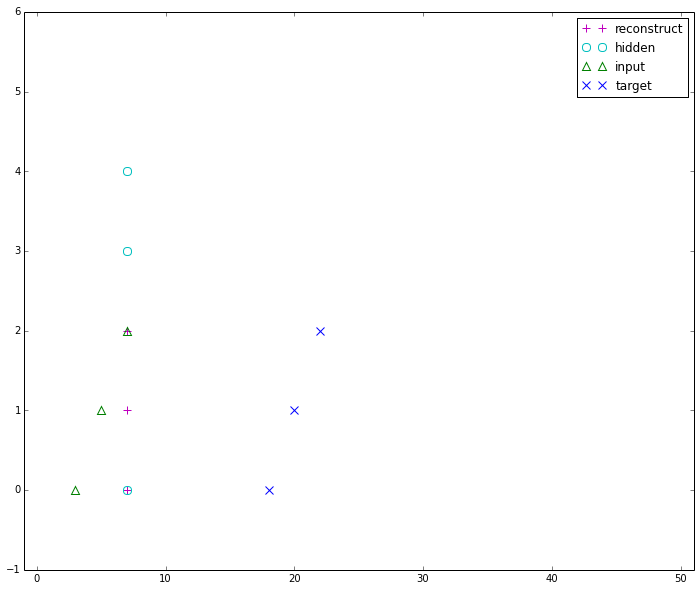

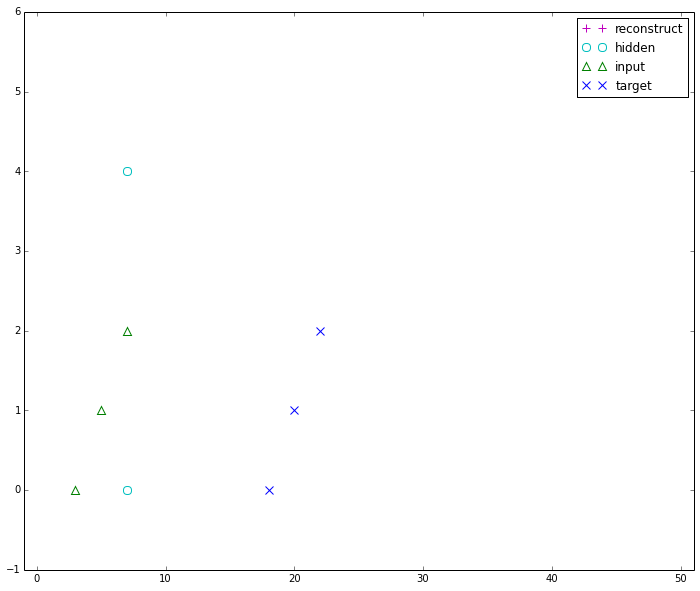

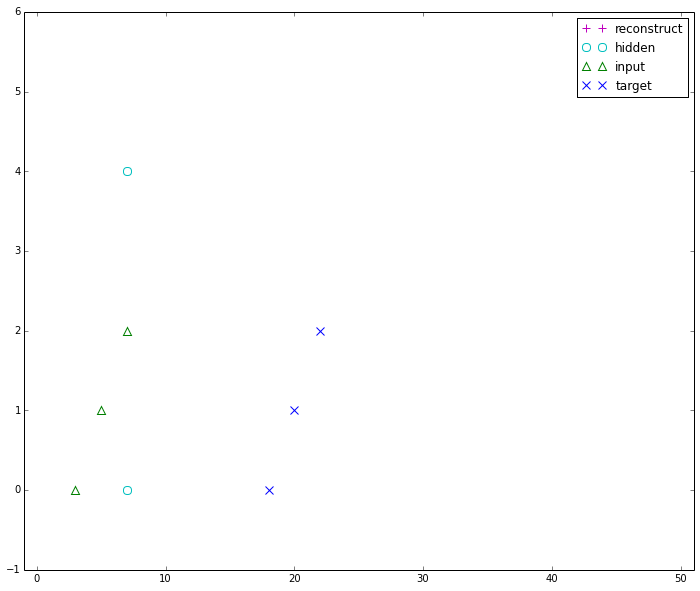

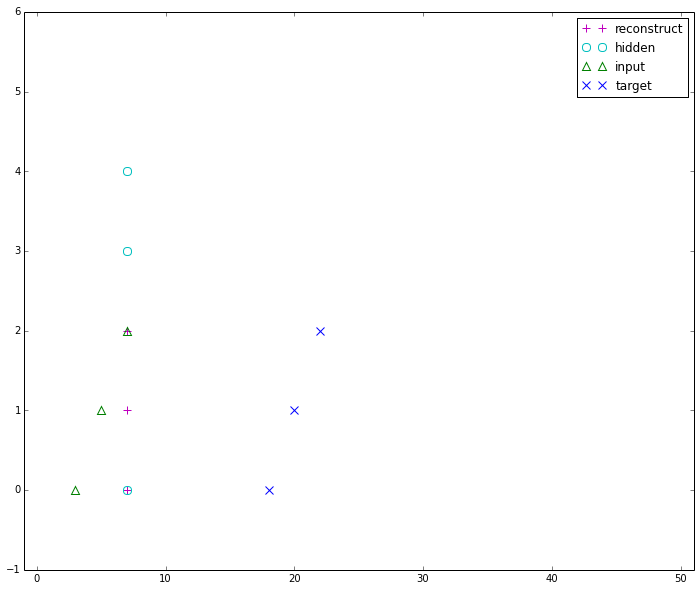

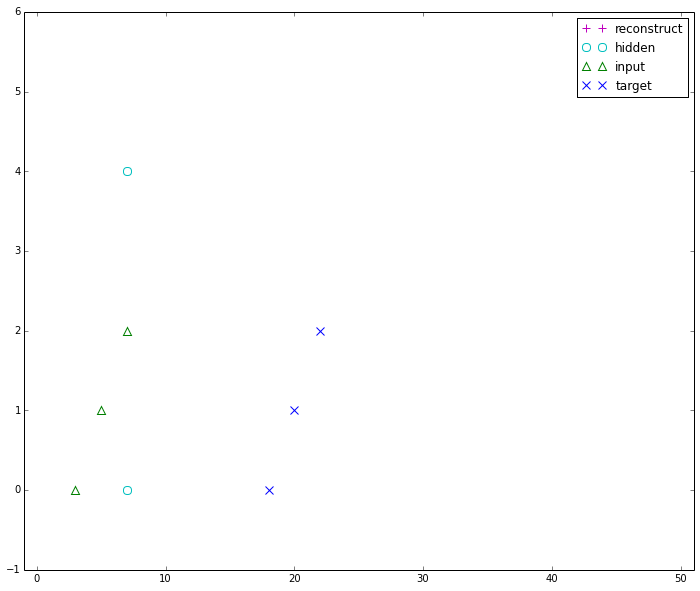

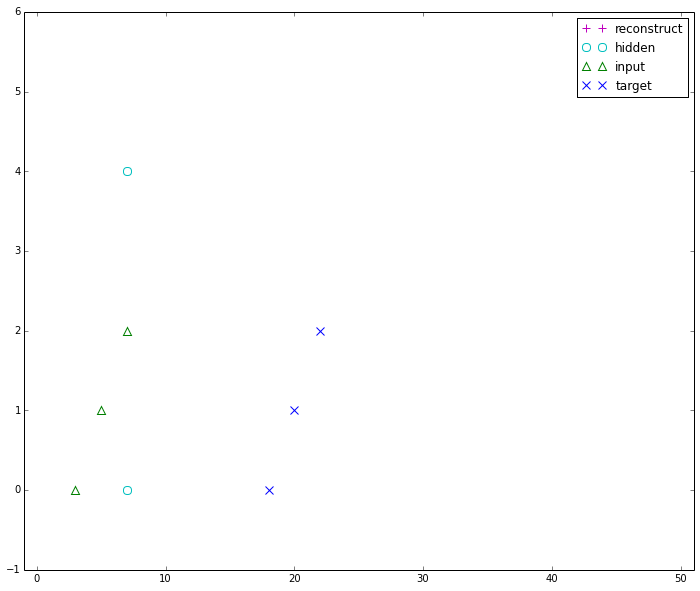

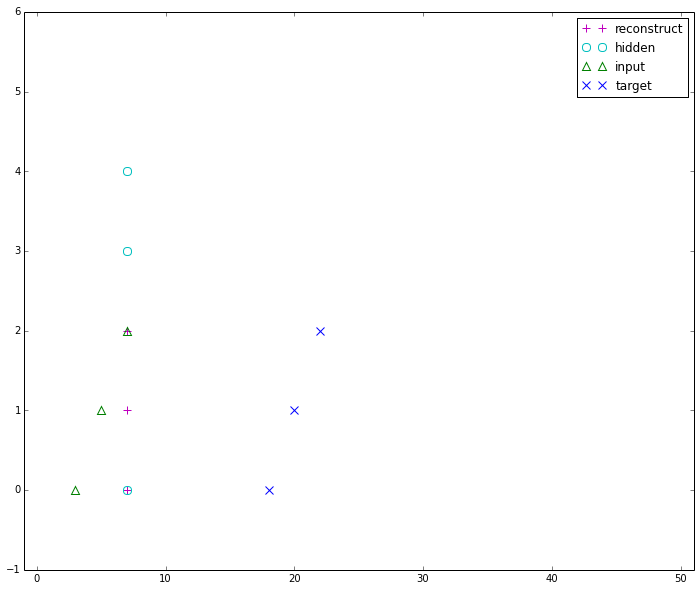

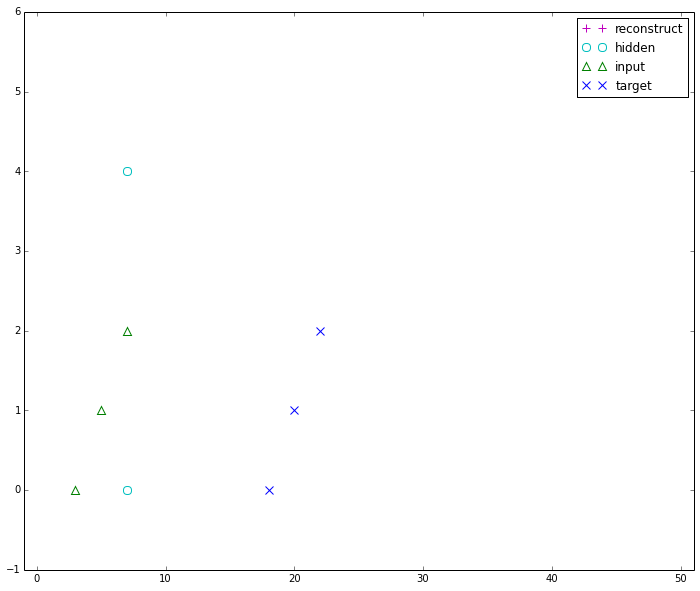

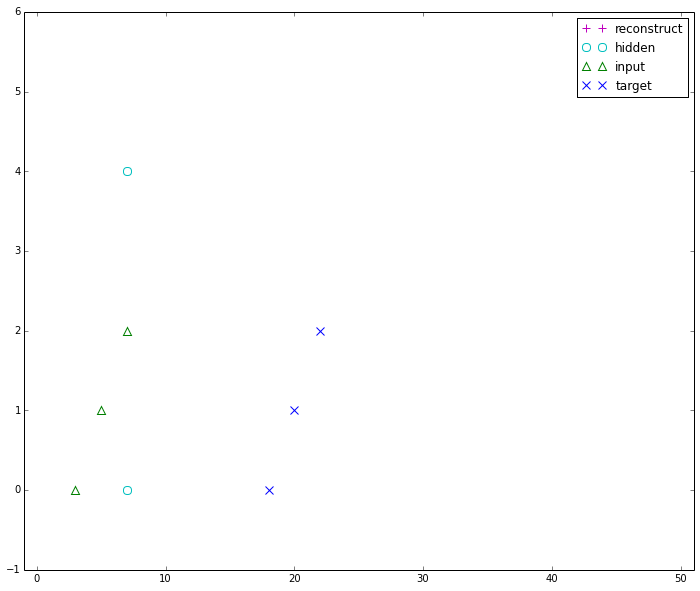

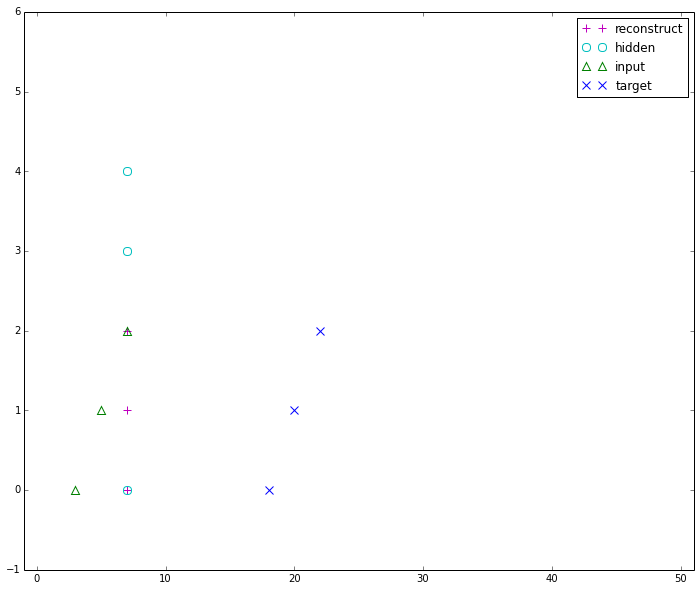

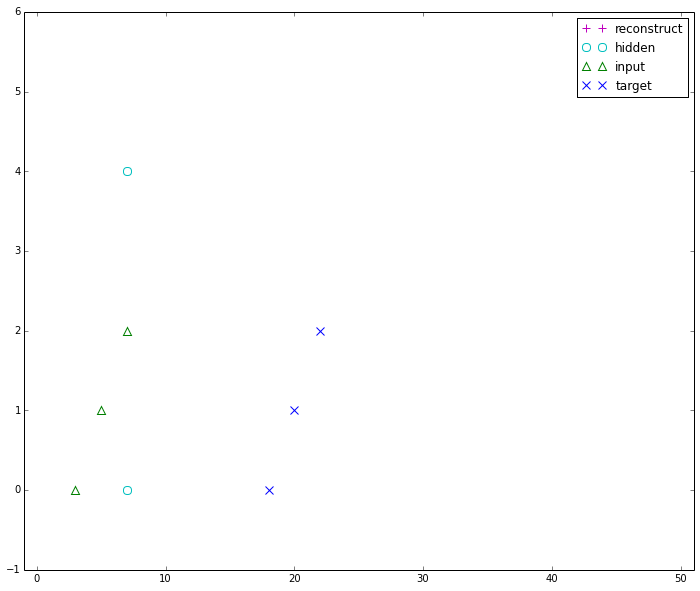

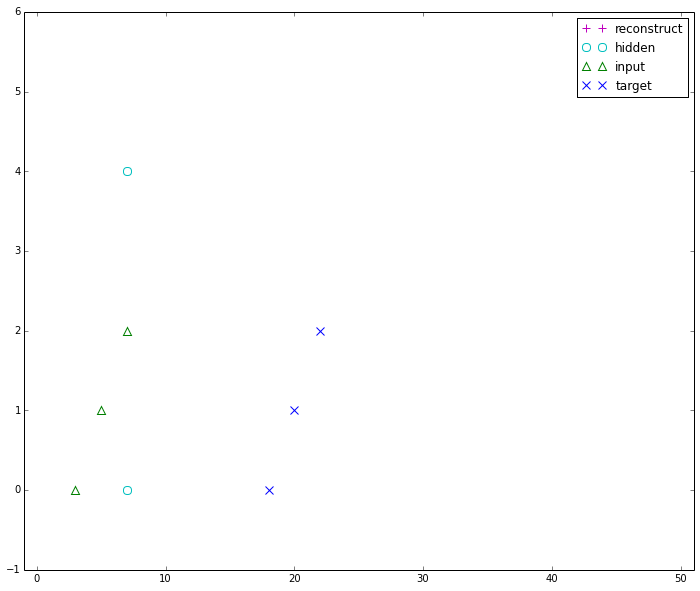

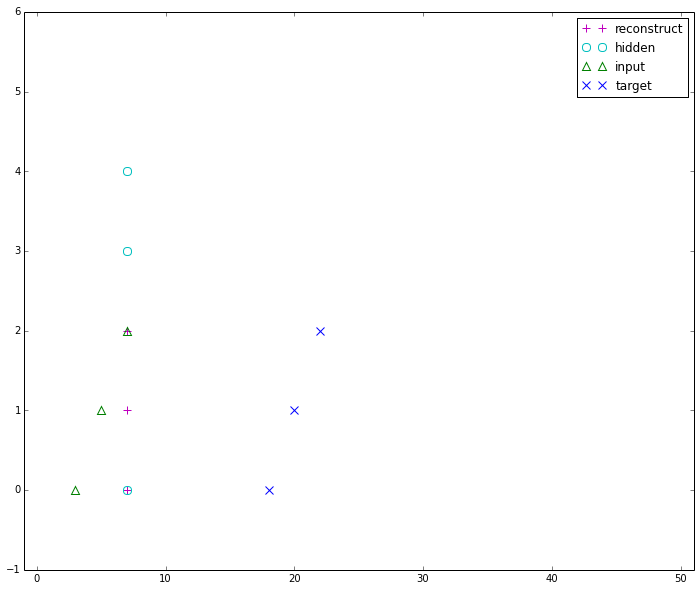

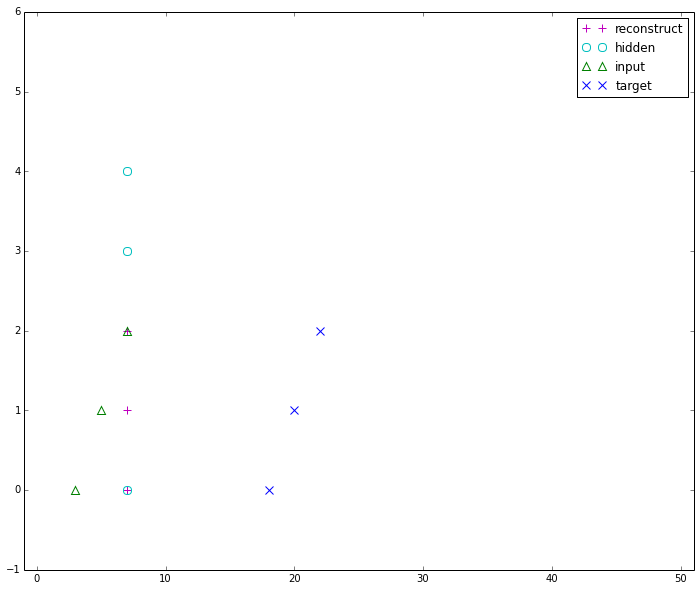

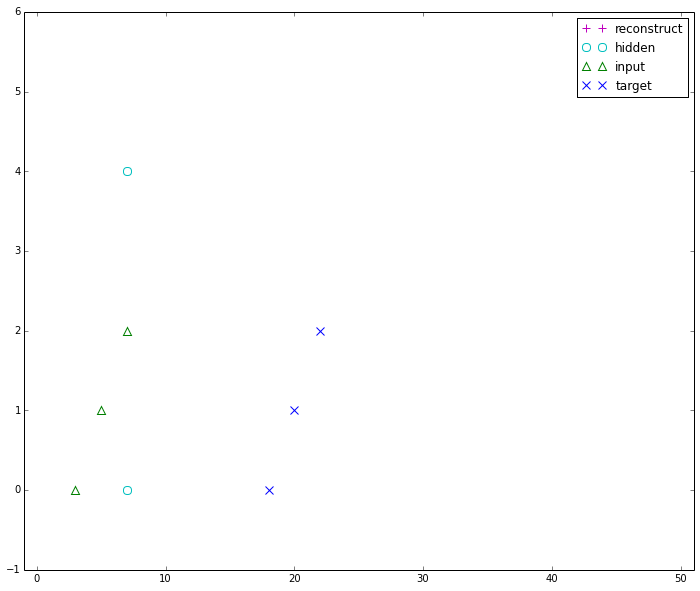

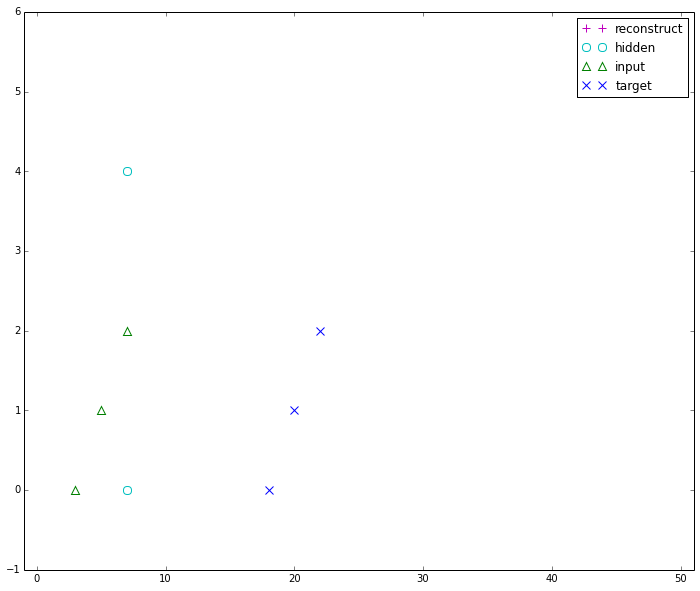

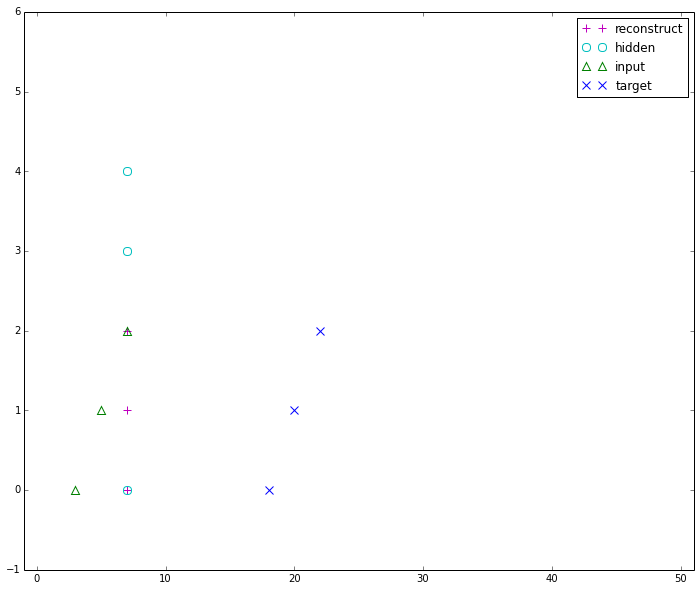

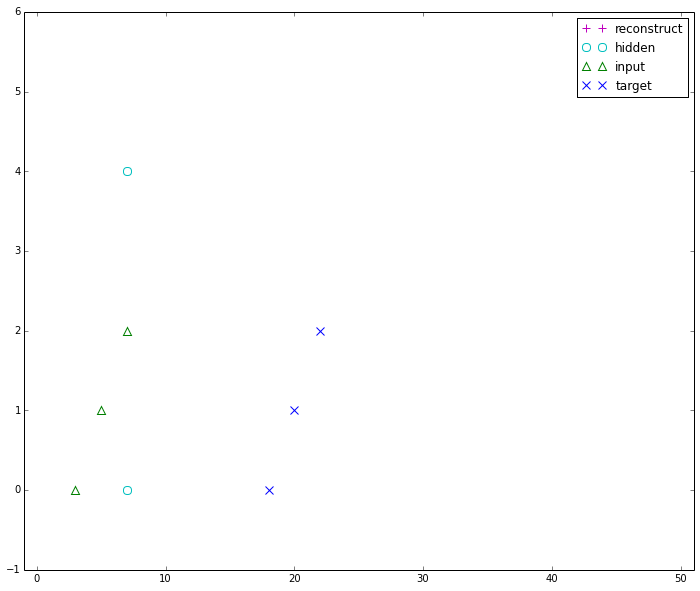

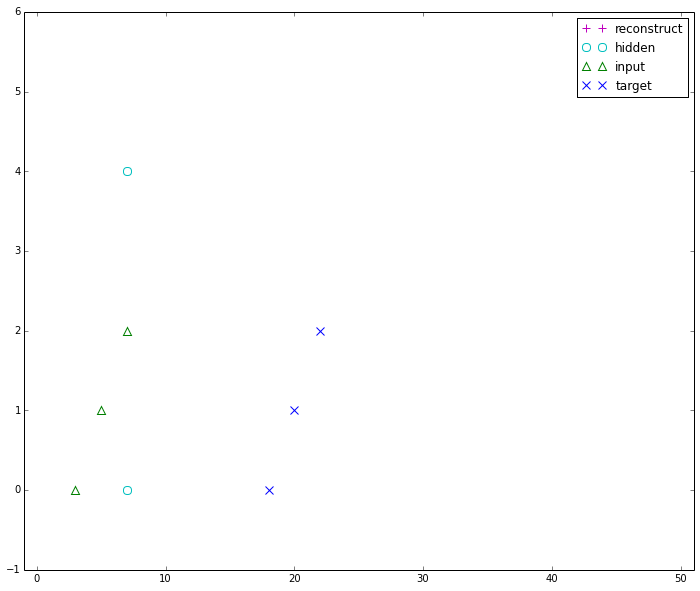

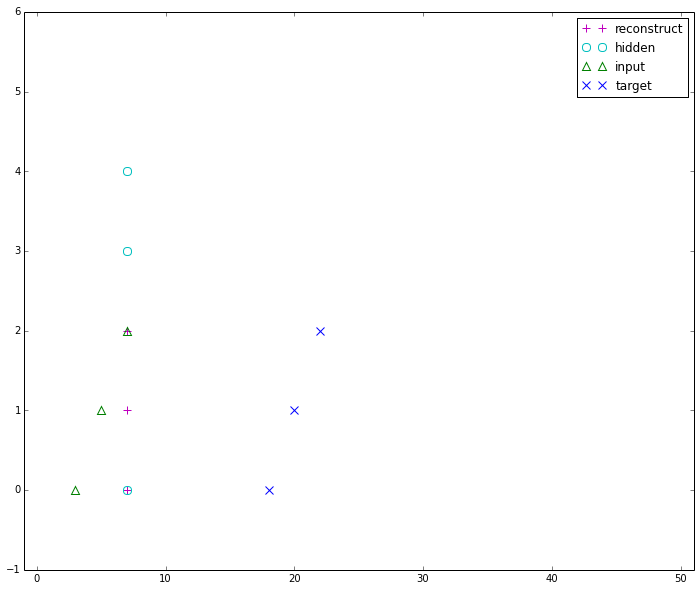

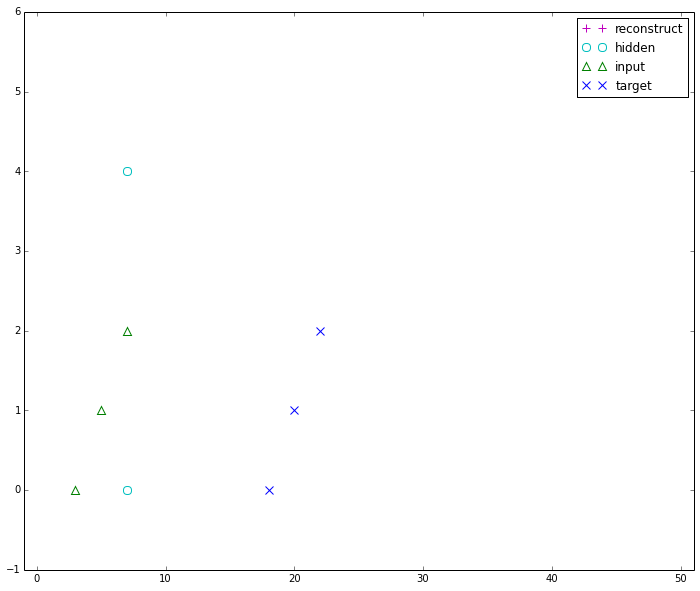

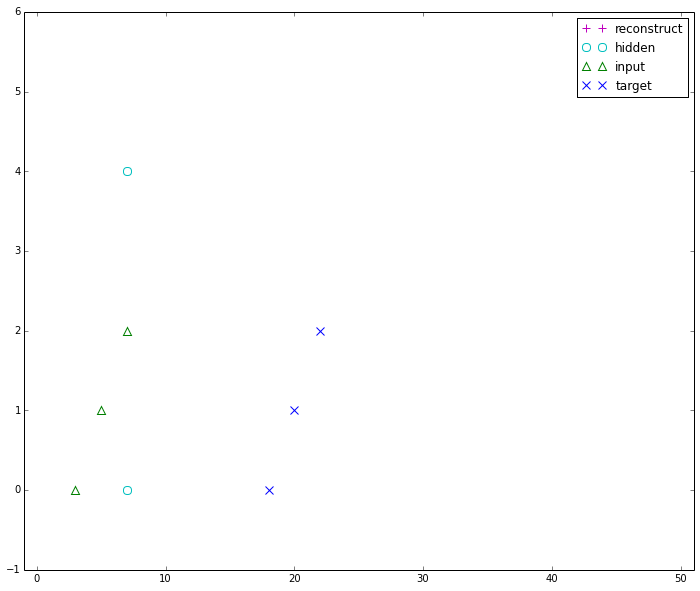

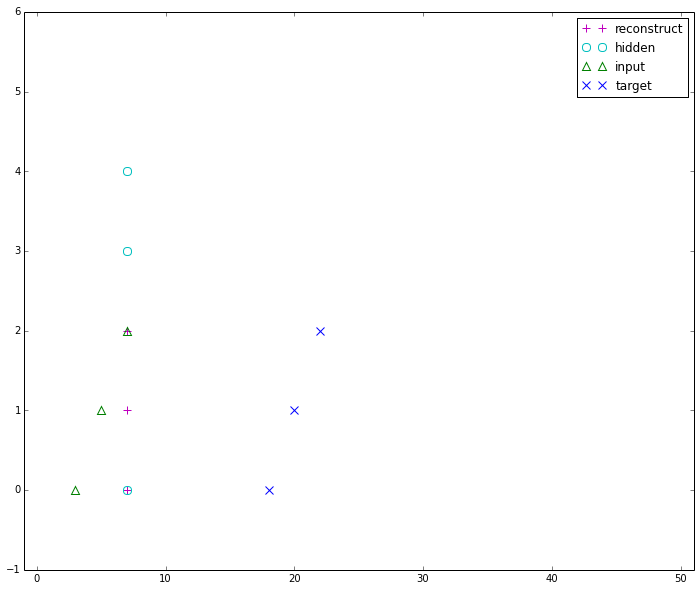

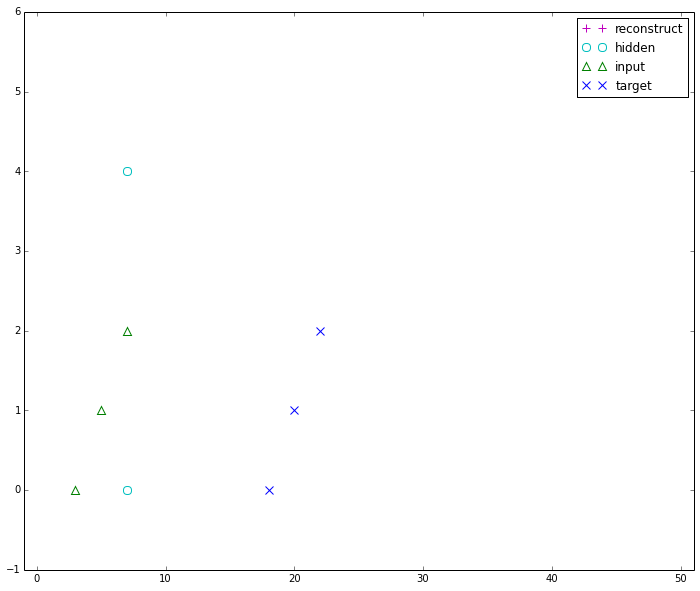

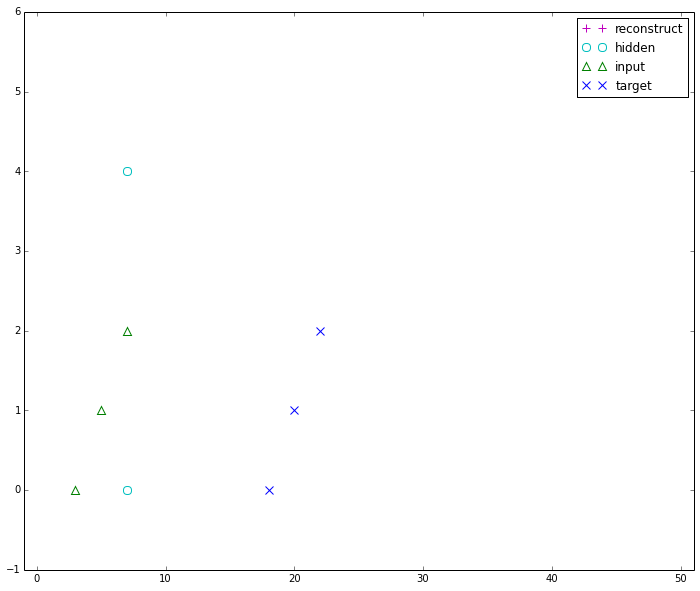

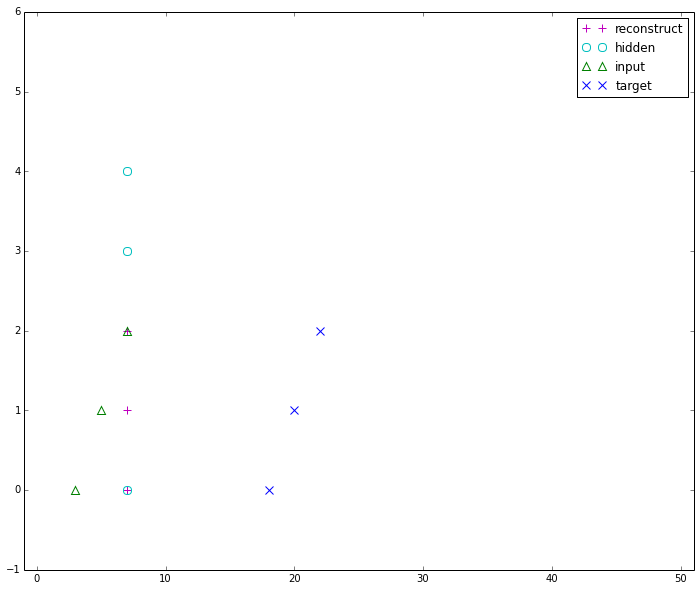

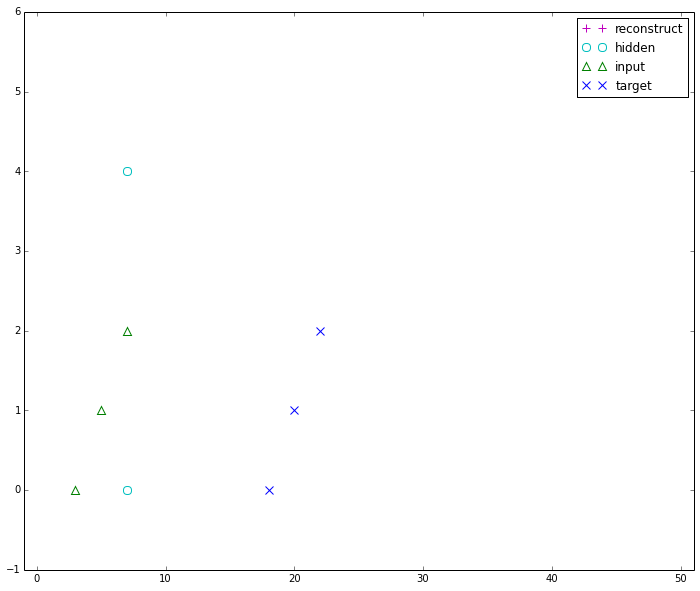

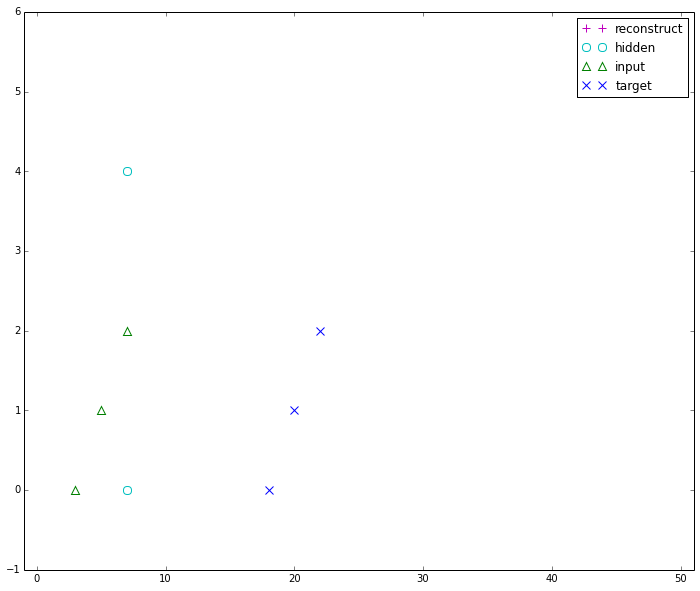

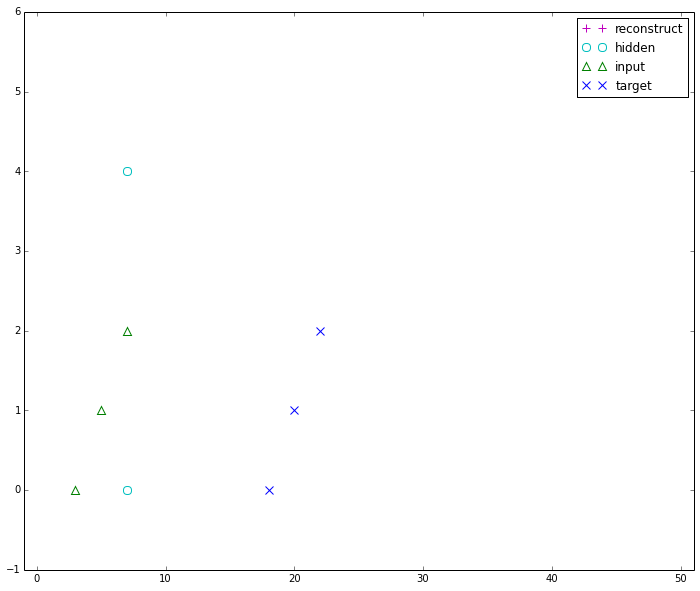

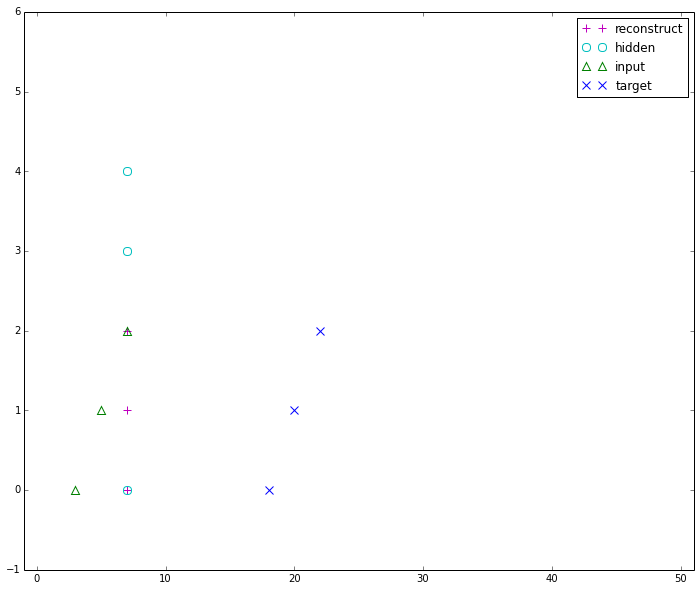

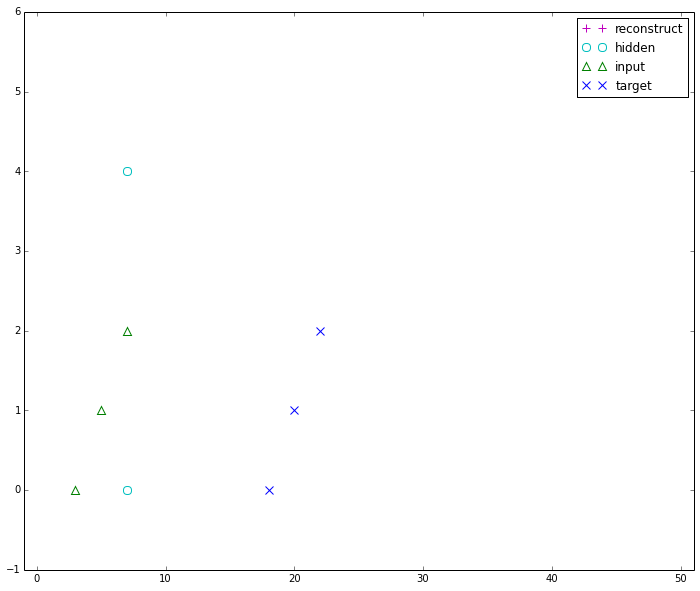

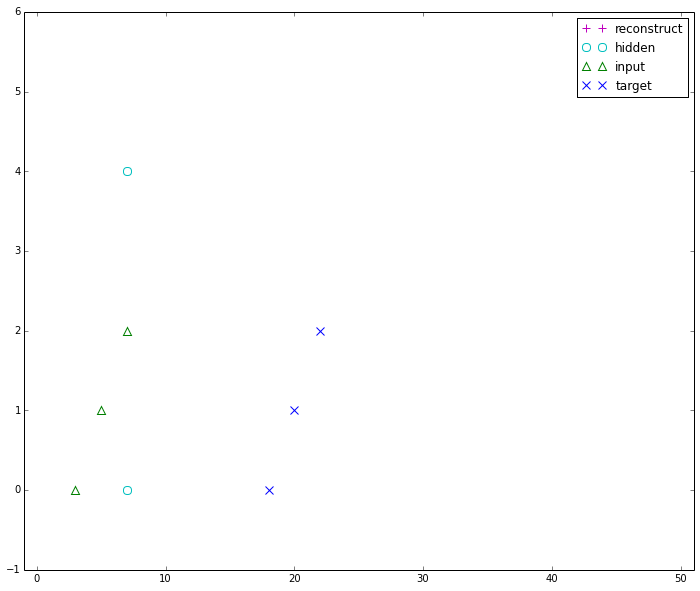

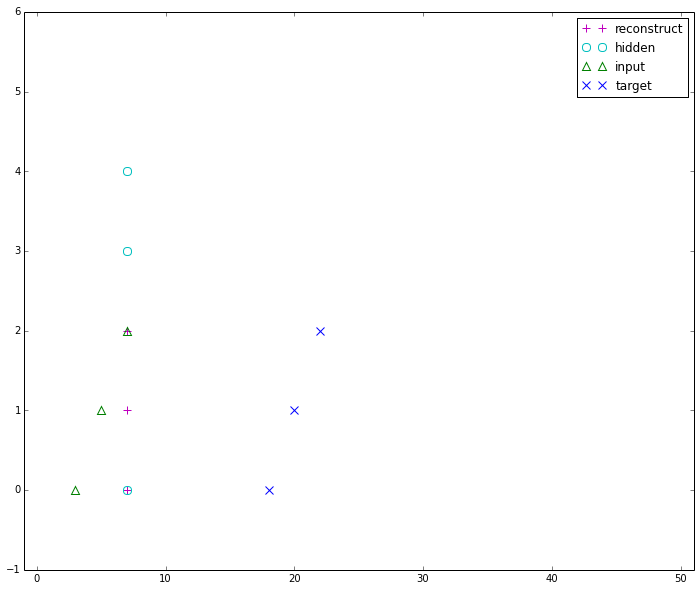

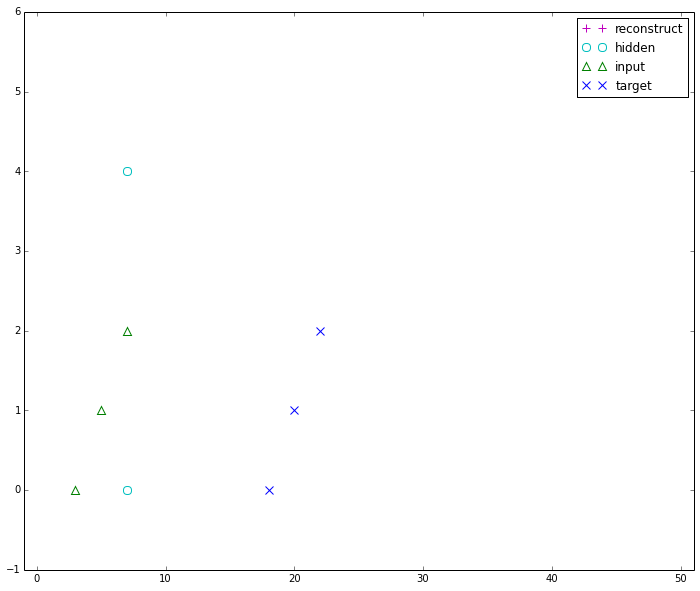

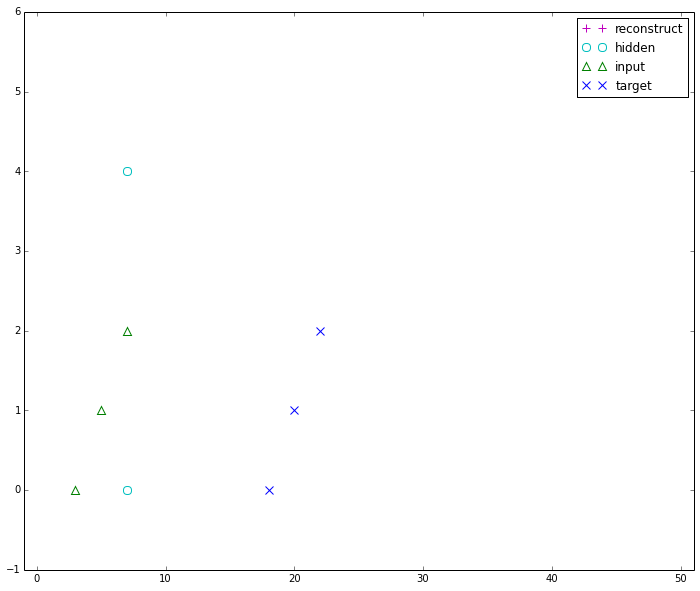

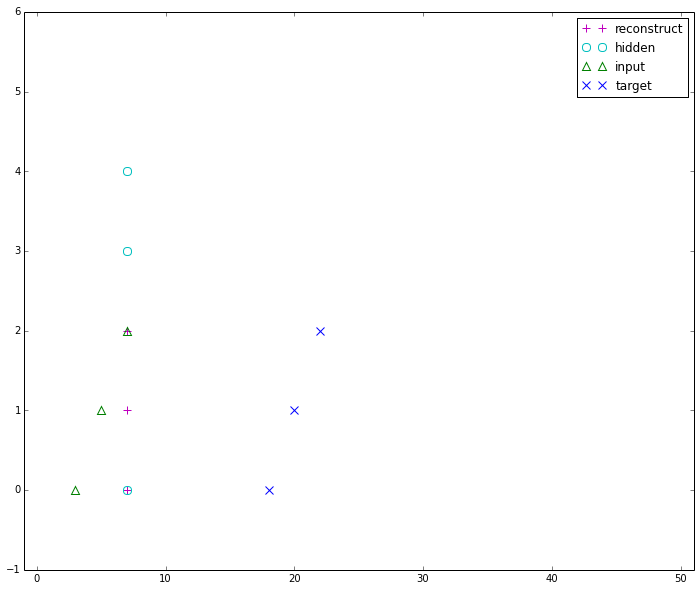

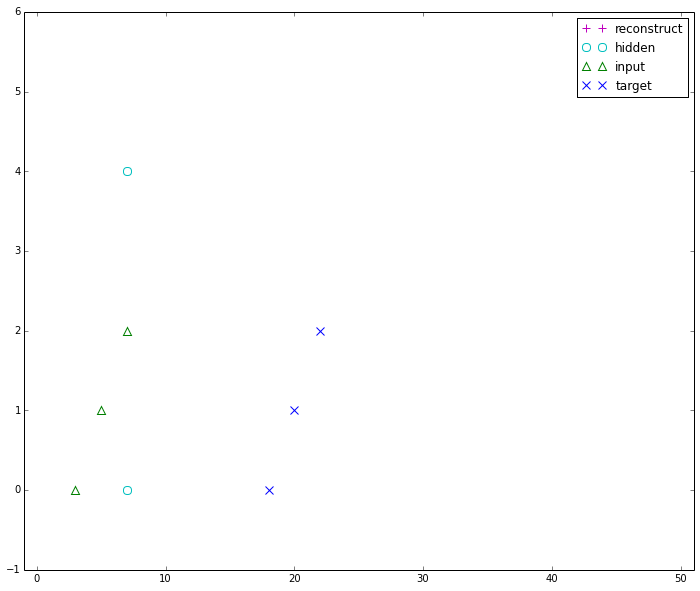

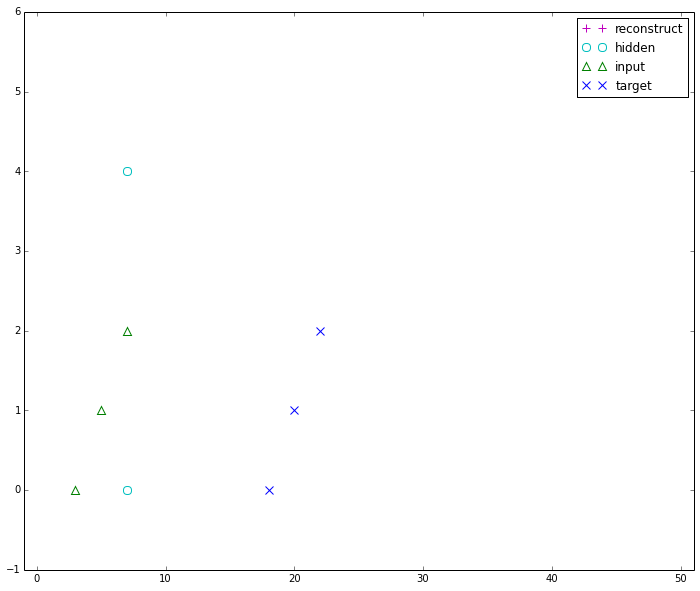

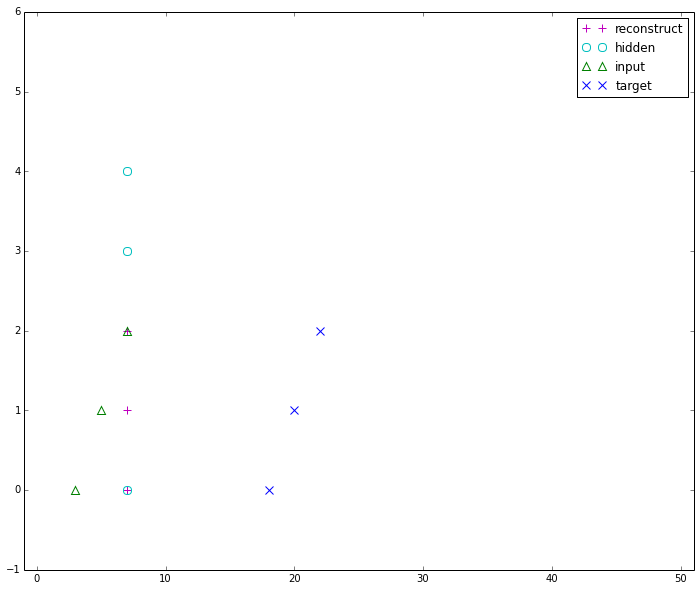

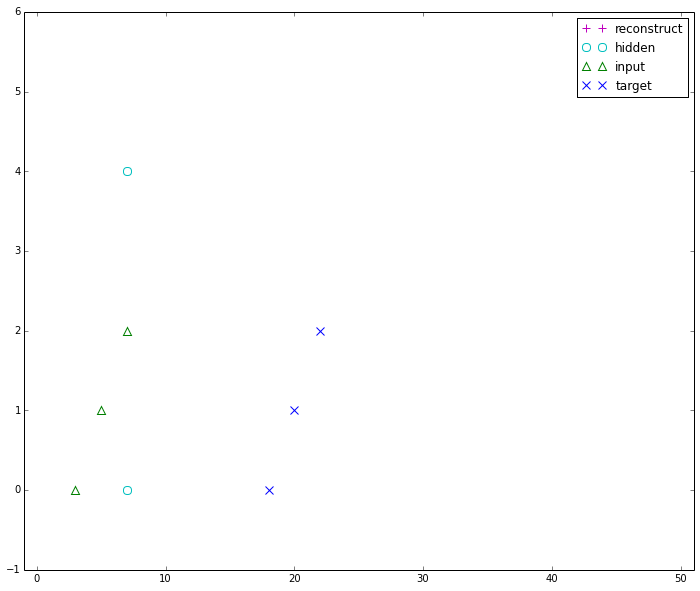

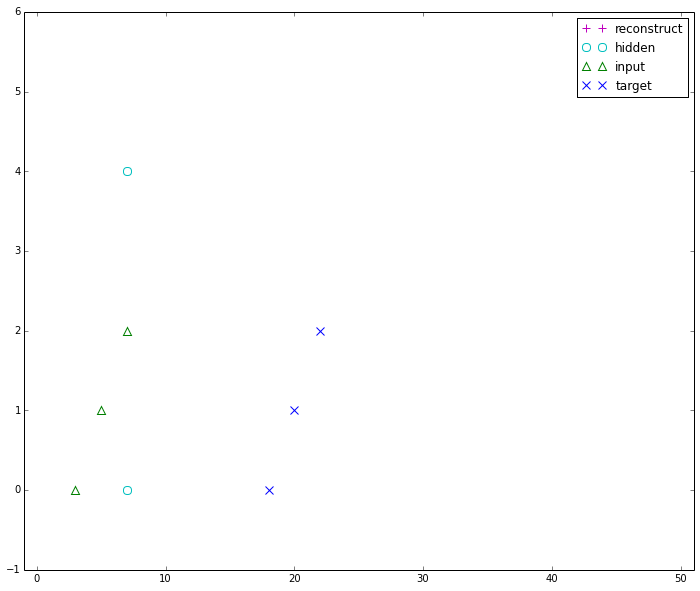

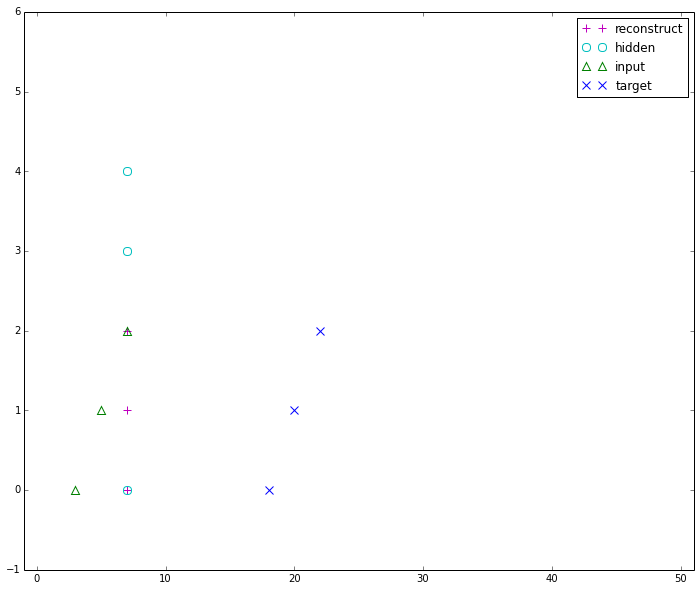

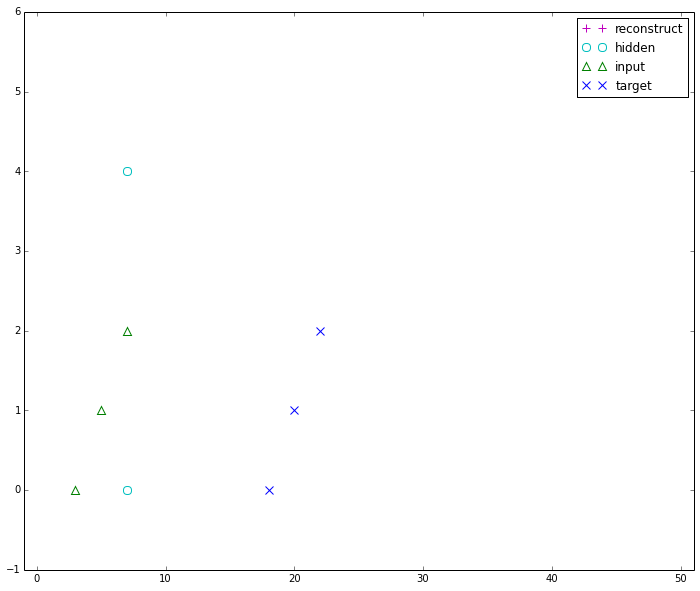

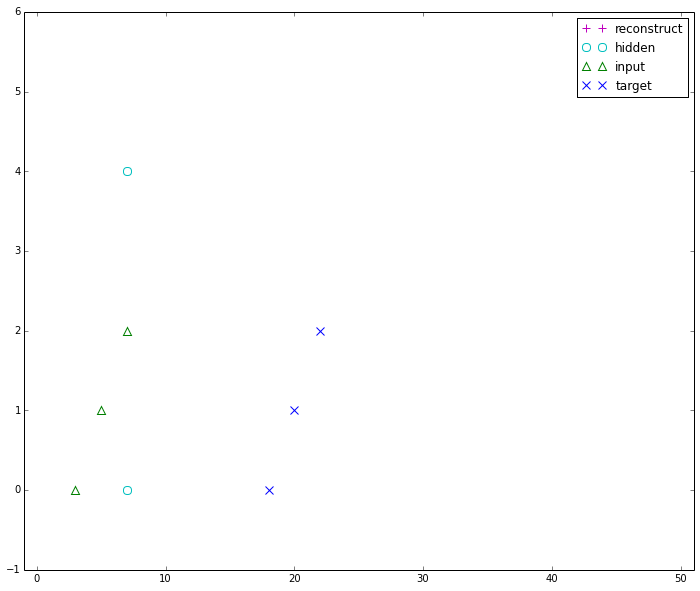

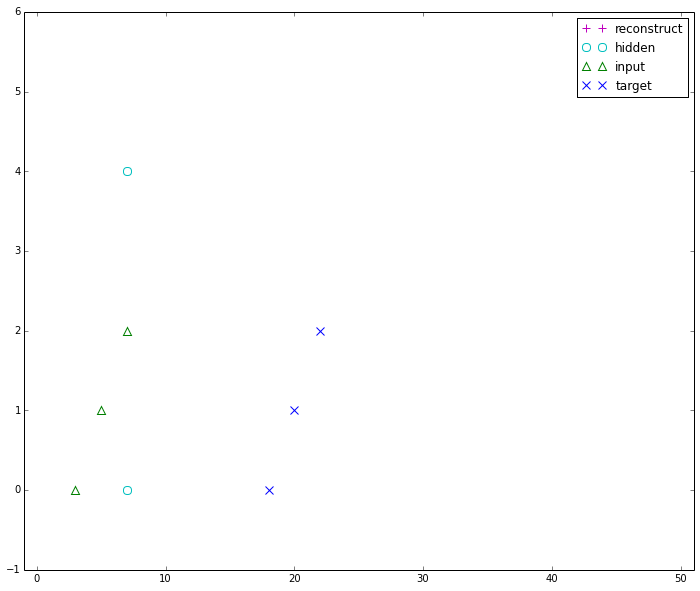

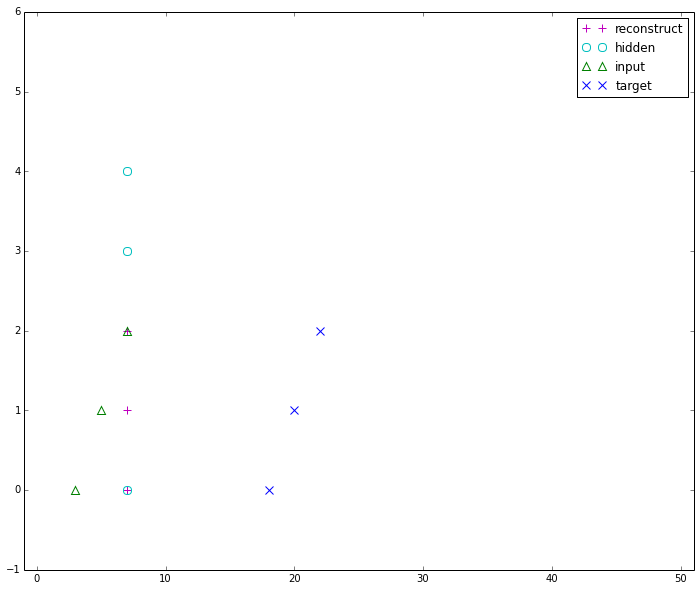

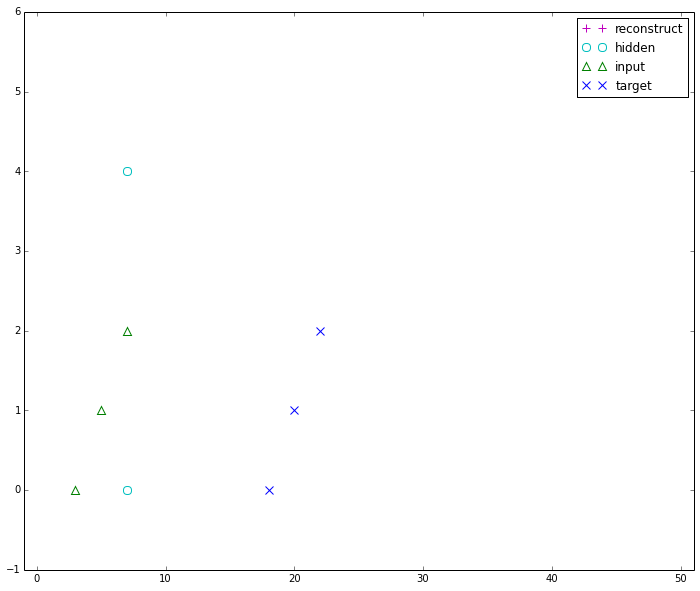

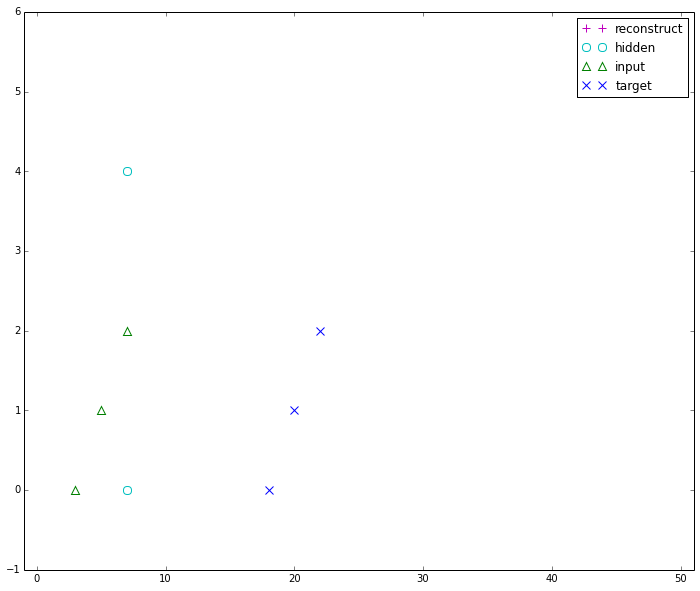

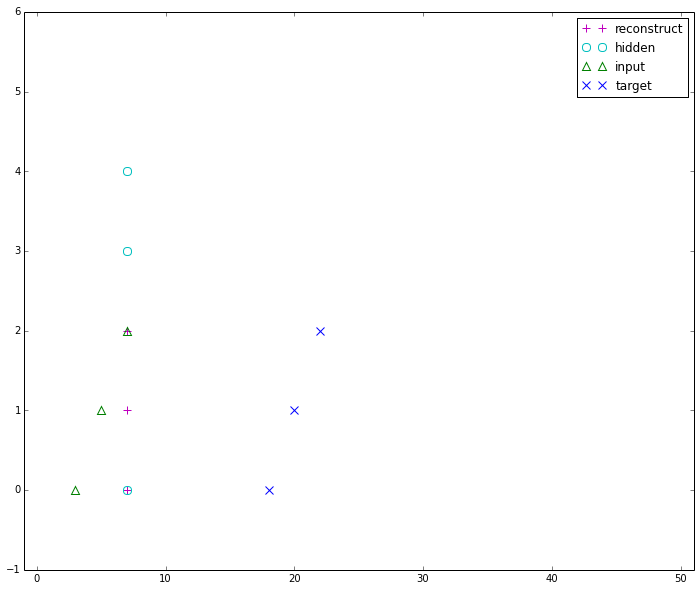

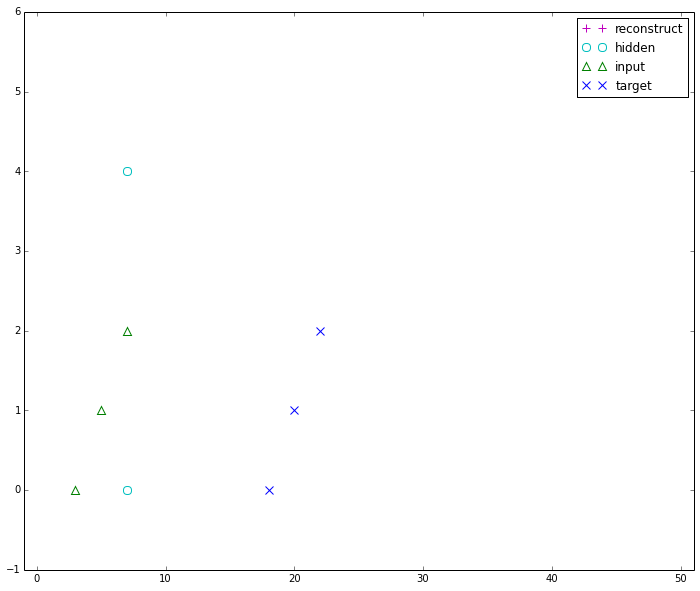

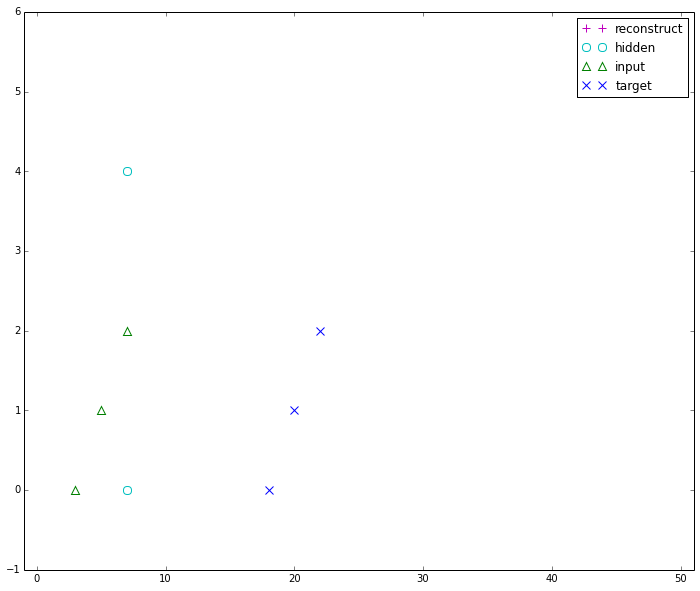

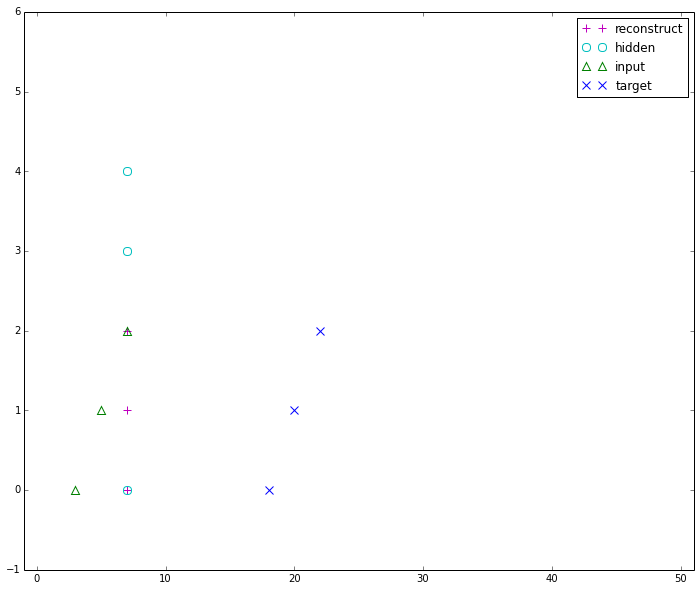

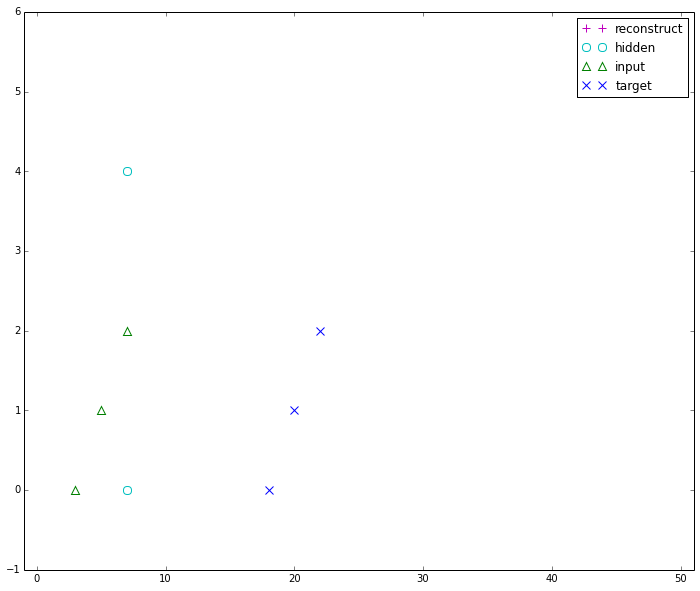

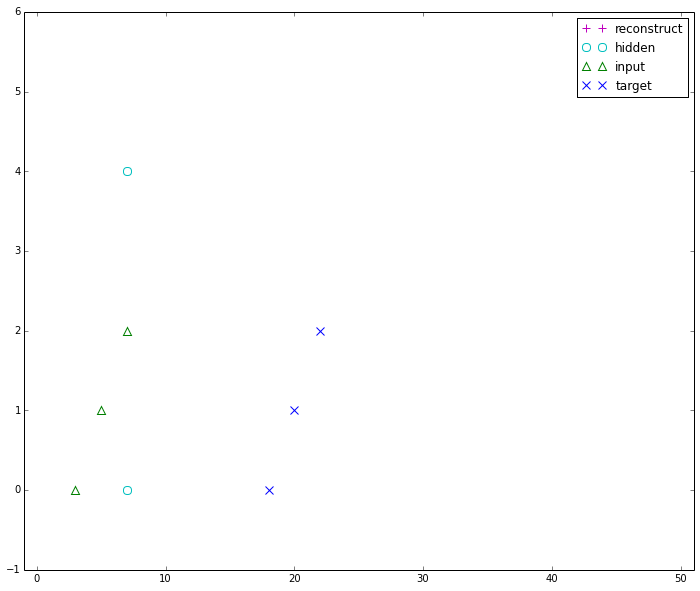

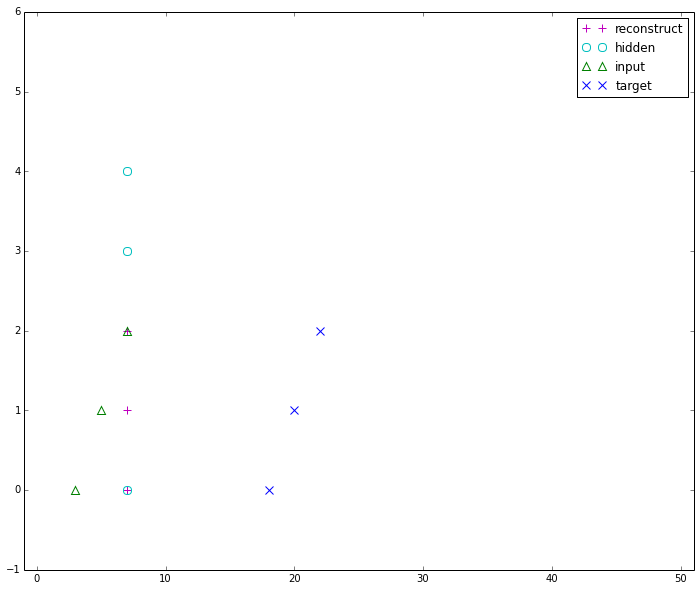

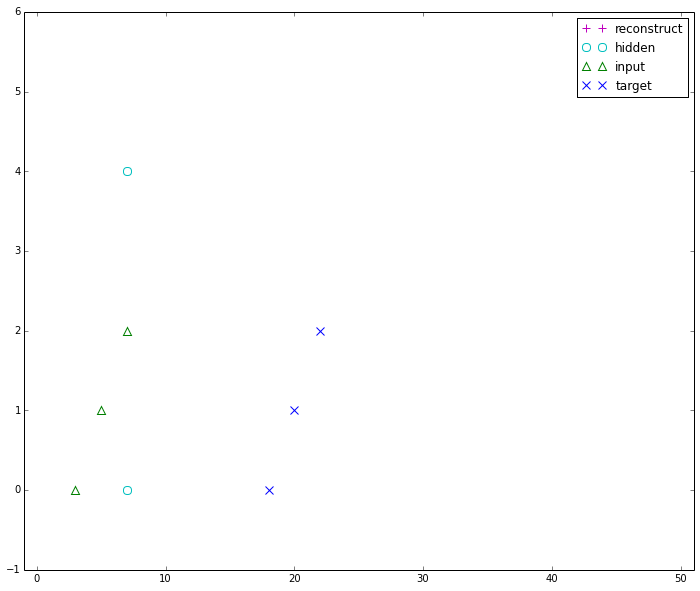

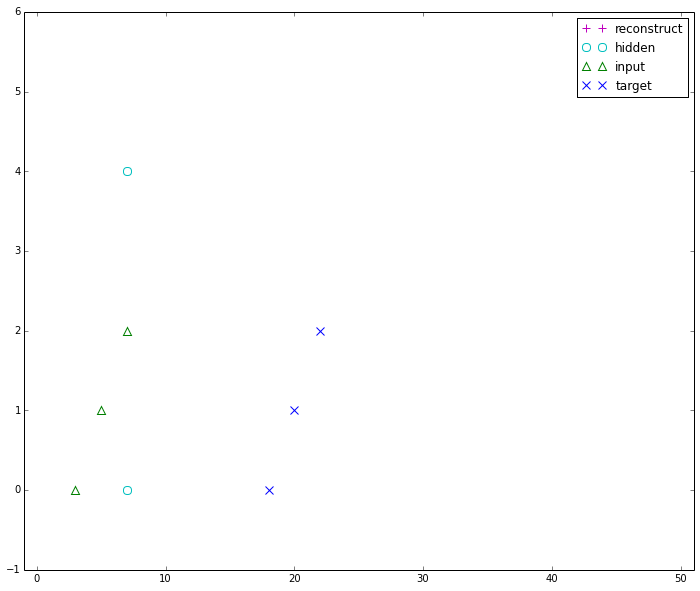

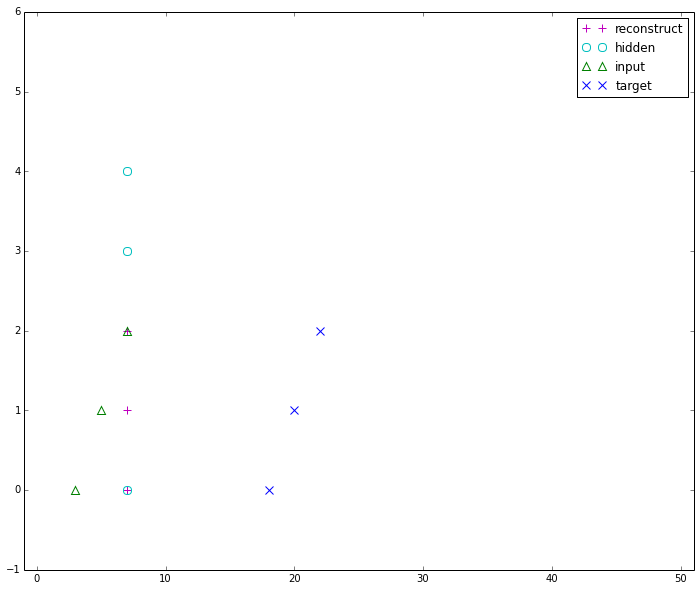

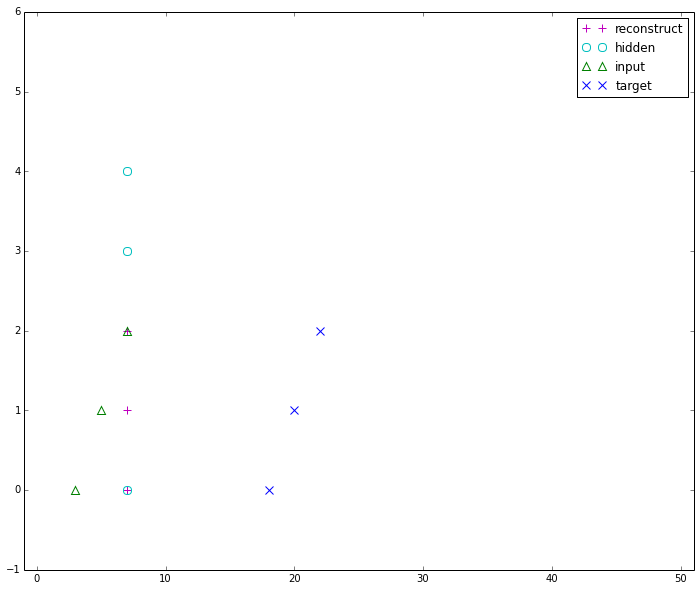

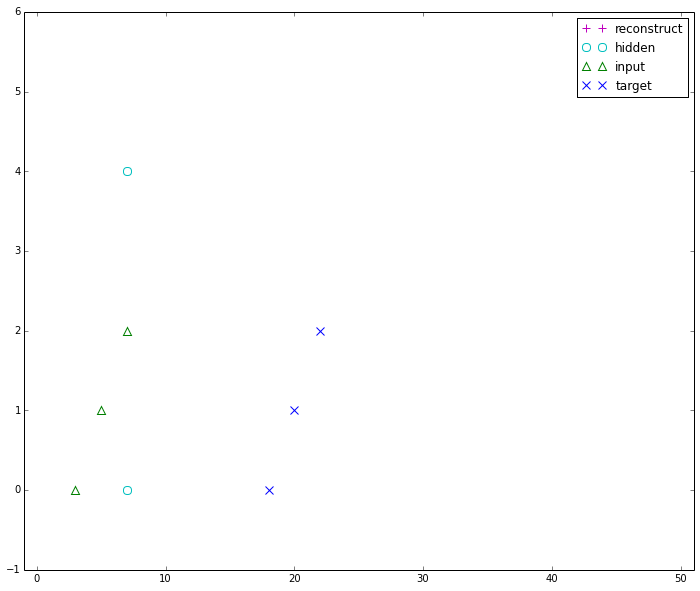

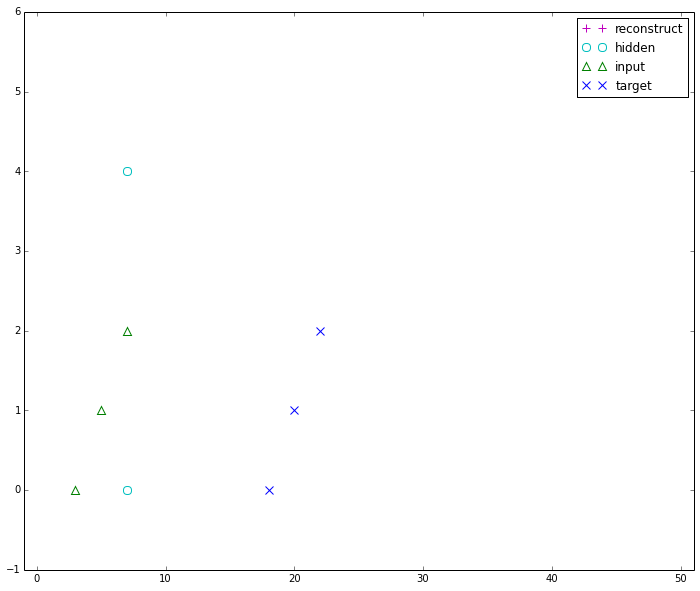

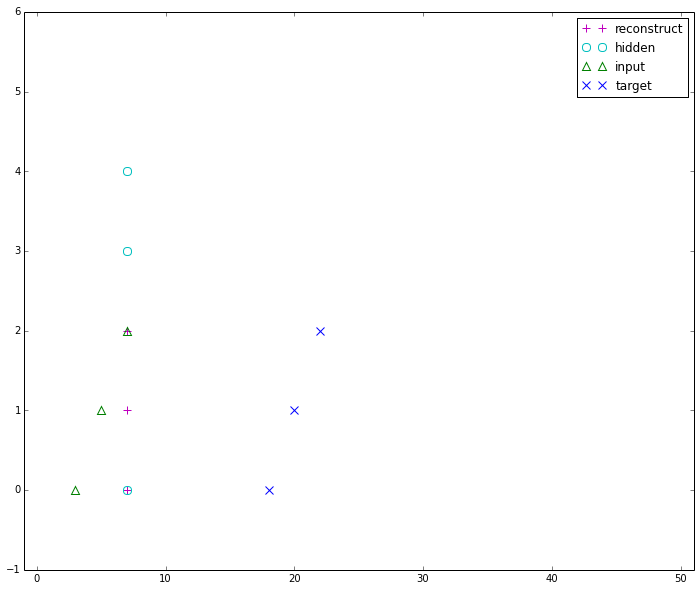

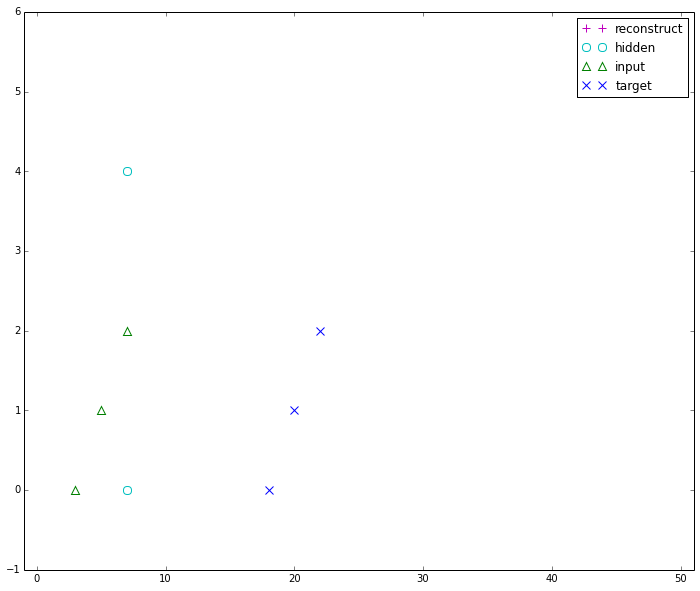

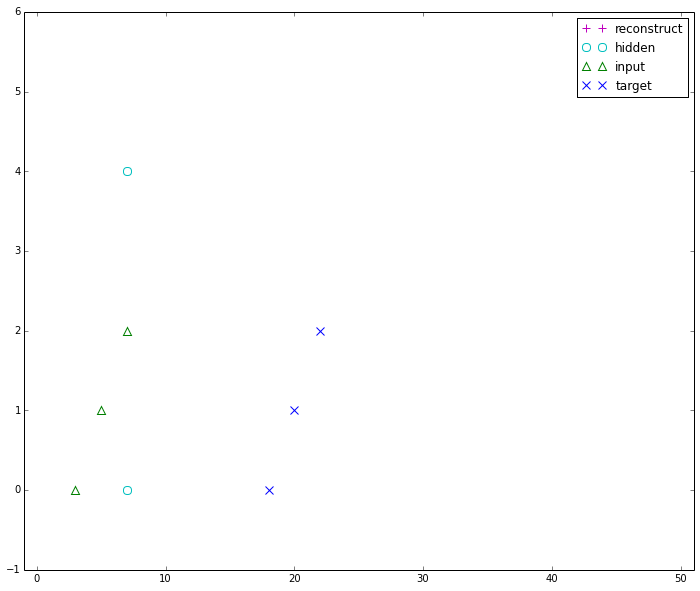

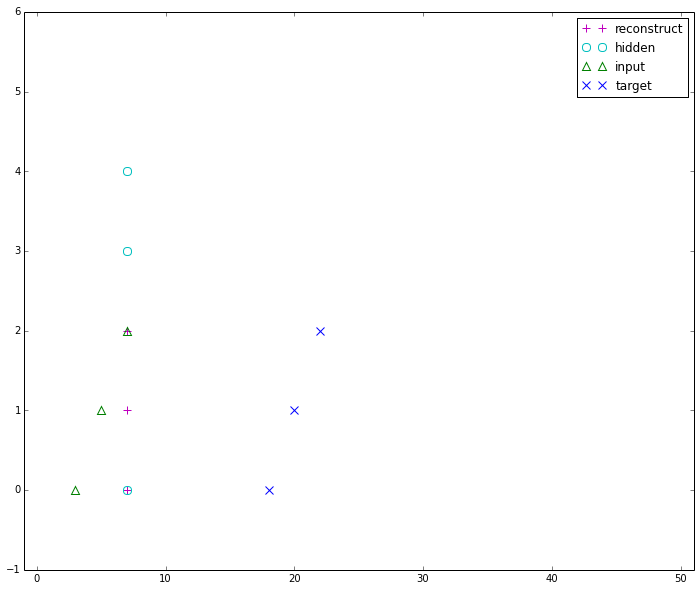

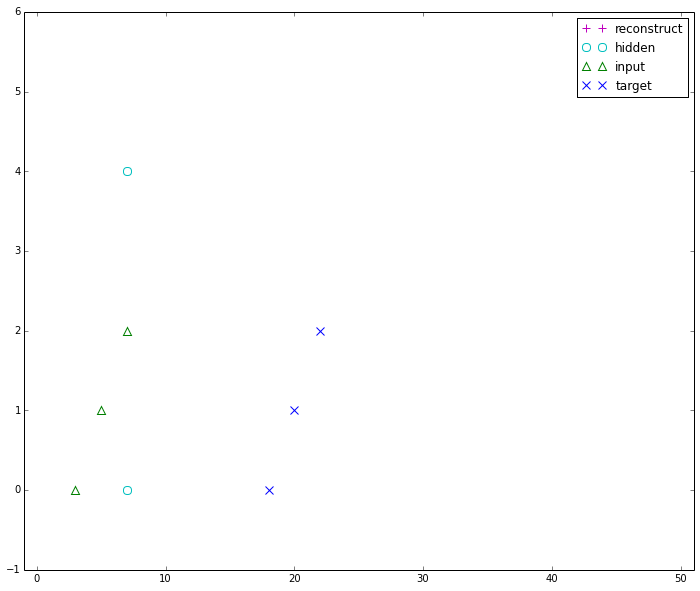

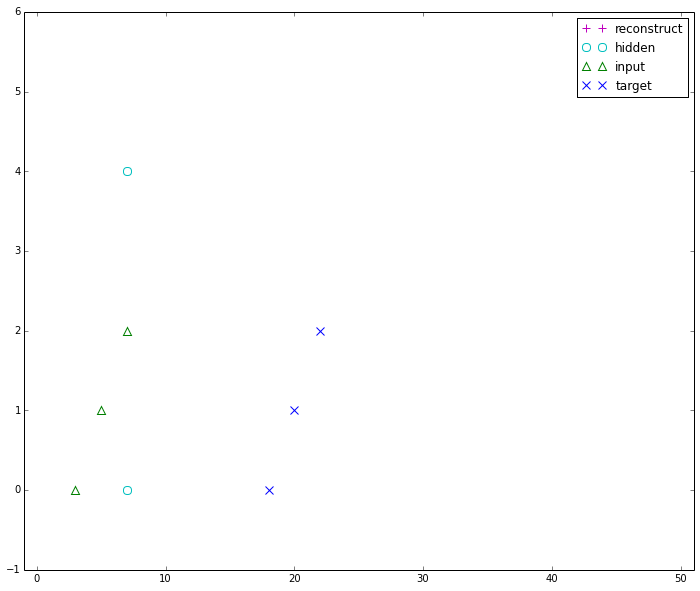

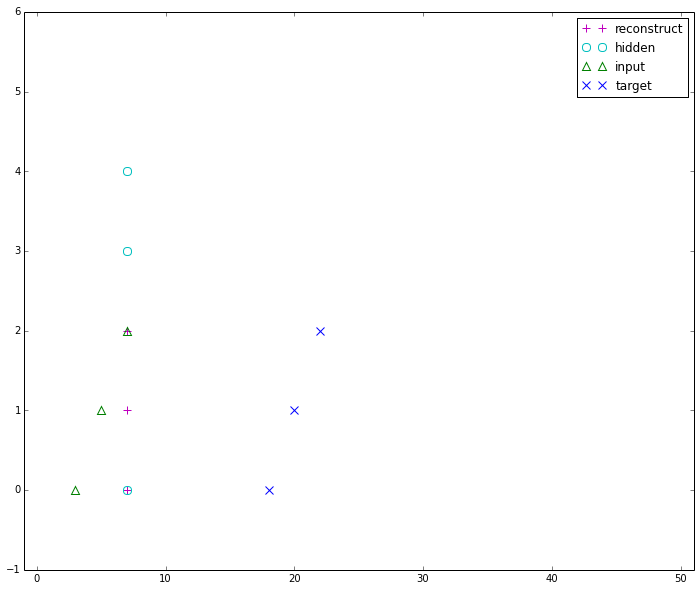

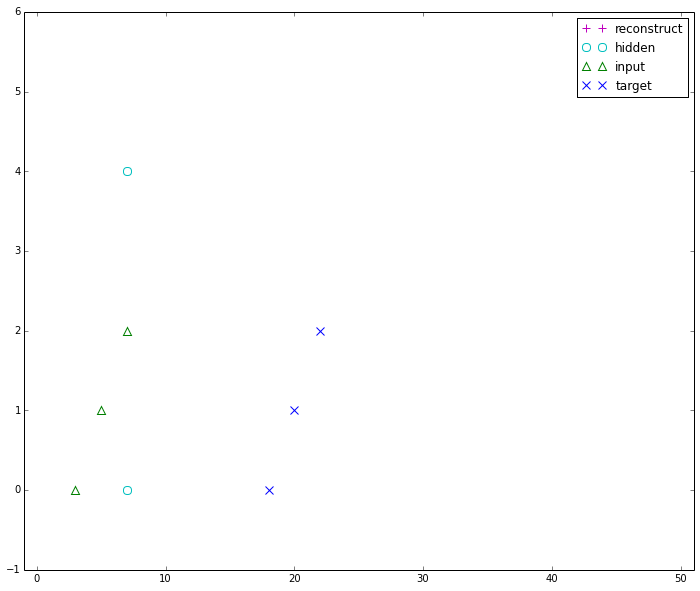

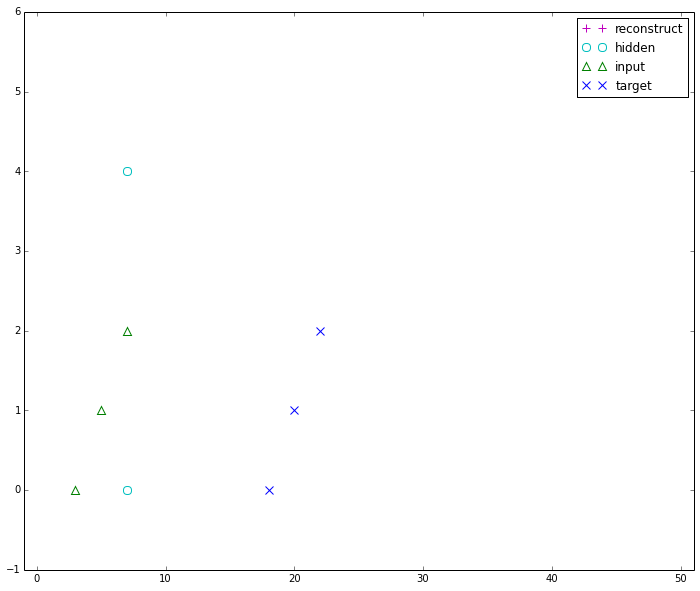

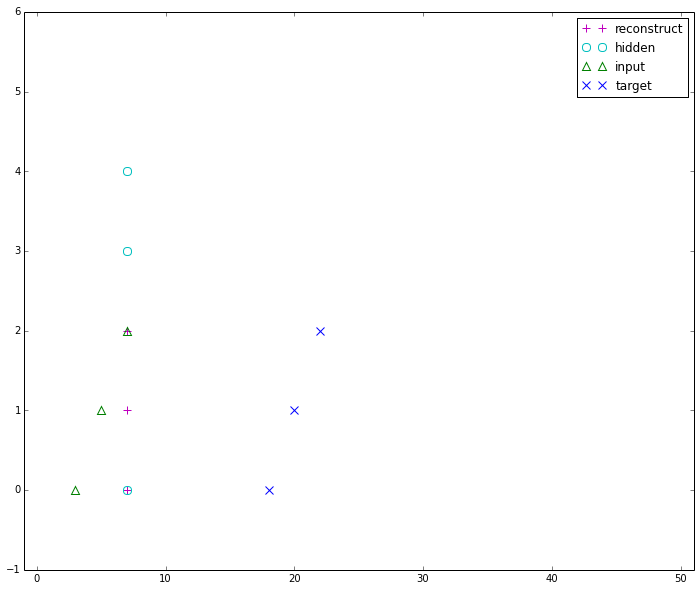

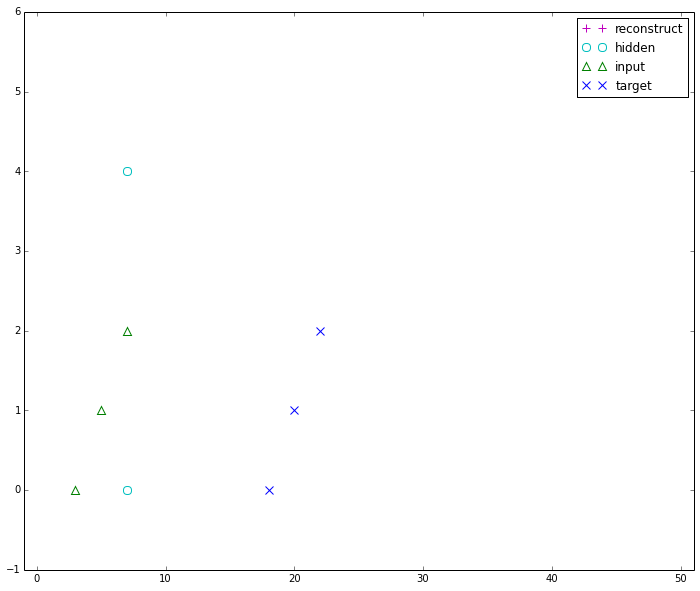

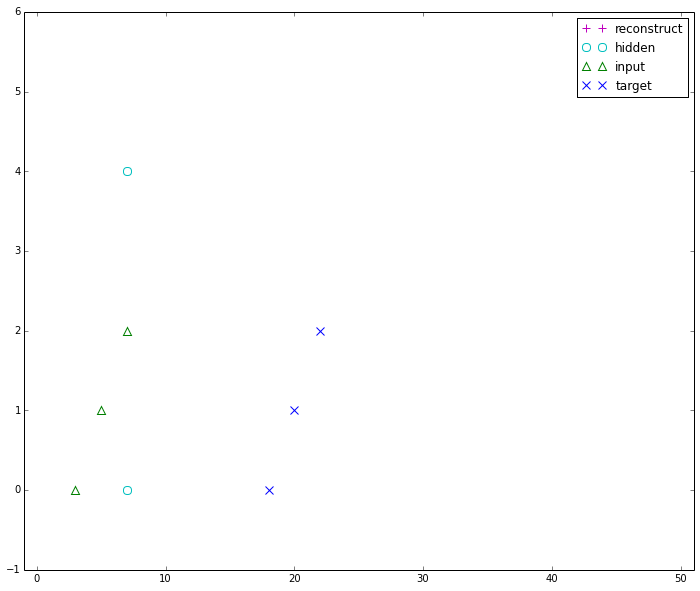

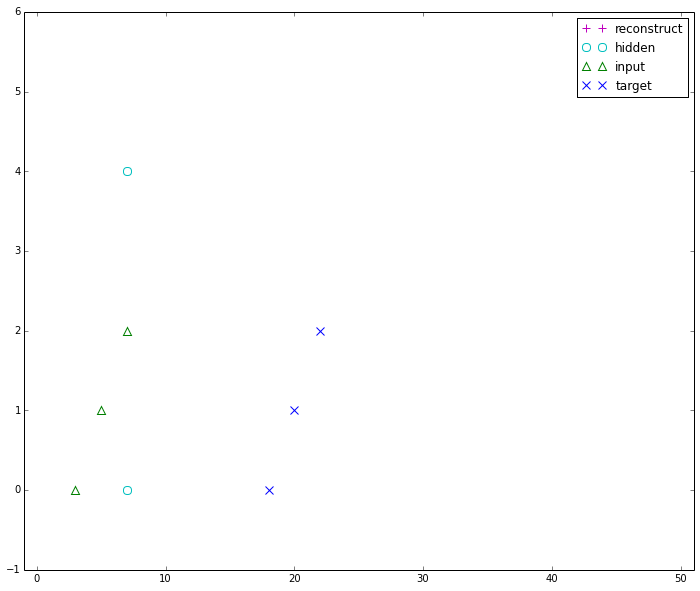

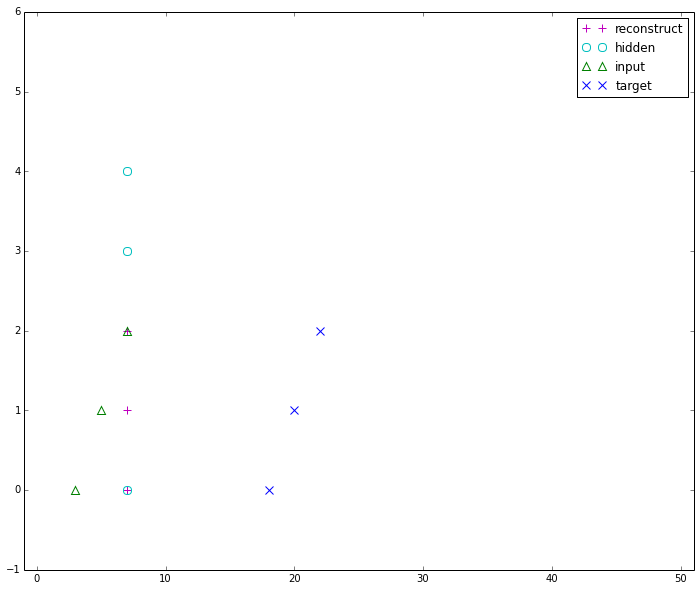

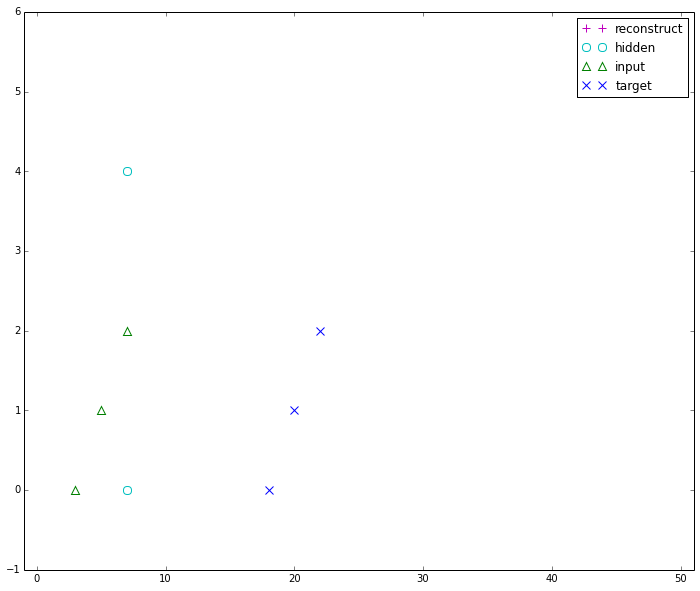

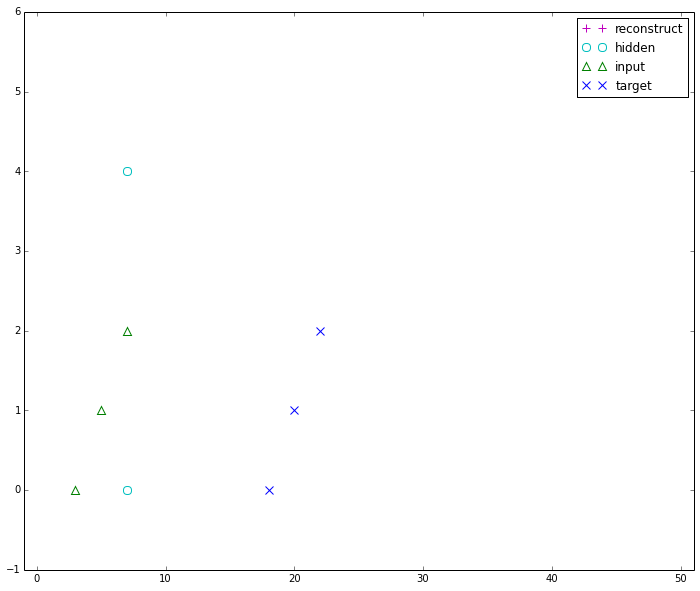

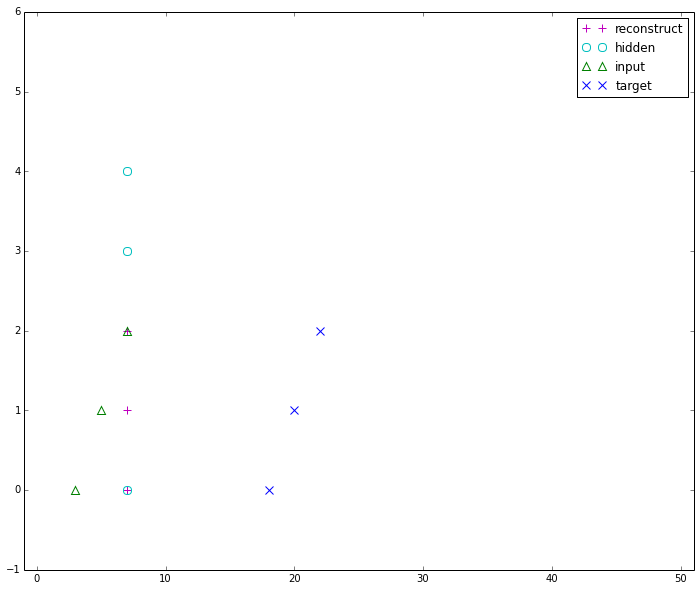

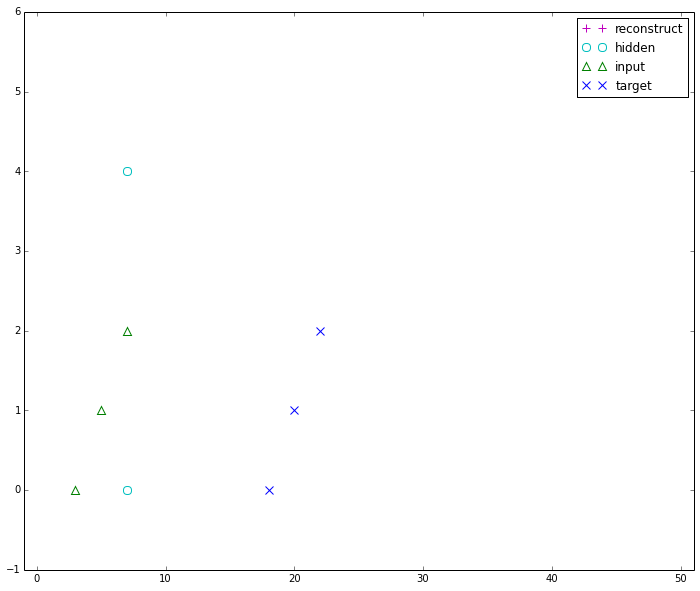

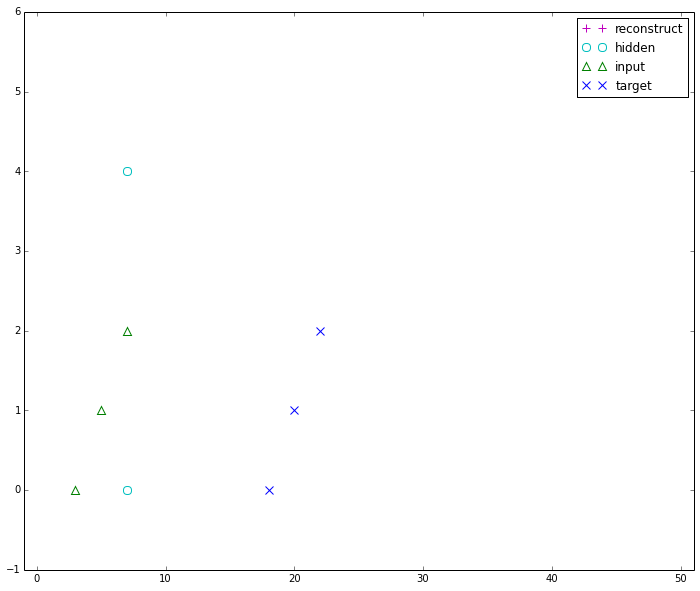

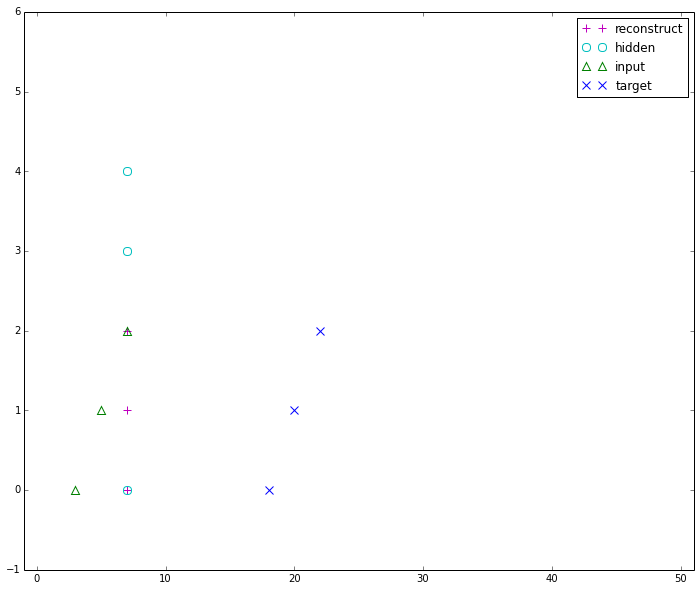

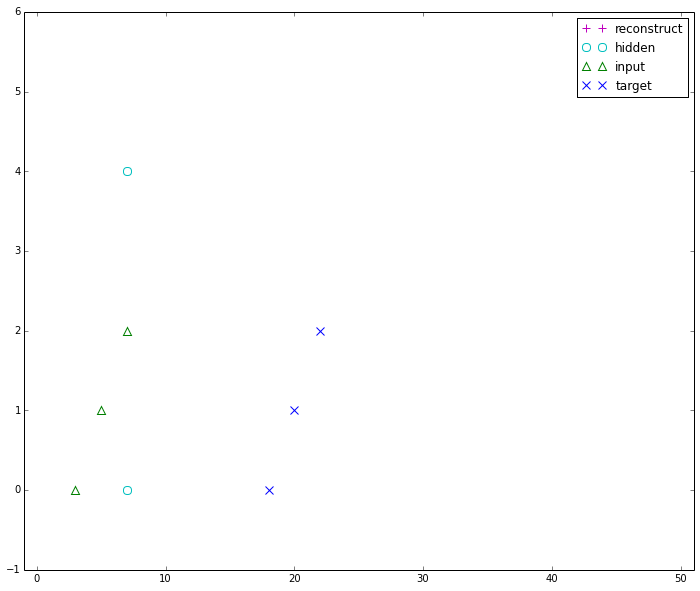

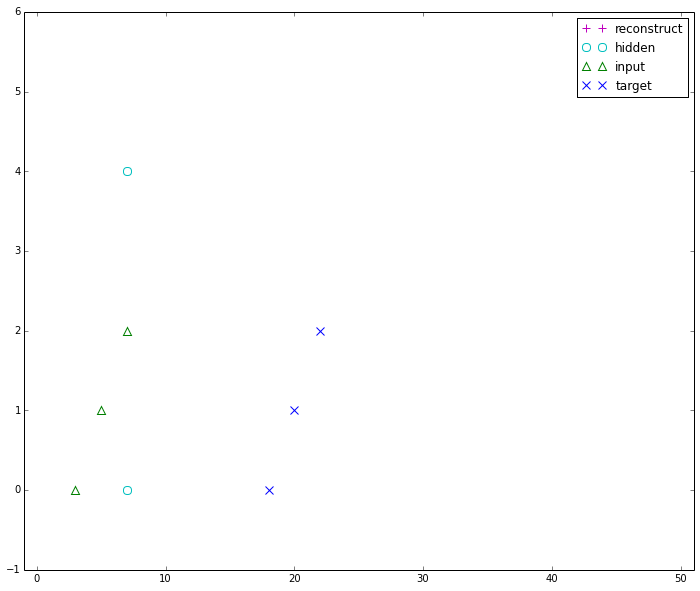

In [5]:
record_flag = True
# Recording of the neural status
if record_flag:
#     h_mem_list = []     # membrane potential of hiden units 
#     h_spike_list = []   # spikes of hiden units 
#     o_mem_list = []     # membrane potential of output units 
#     o_spike_list = []   # spikes of output units 
    w_list = []         # weights
    loss_list = []
    predict_list = []


lvl_0 = AELayer(description)
prev_w  = lvl_0._w.copy()
period = 33
epoch = 60000 # training epochs
num_test = 1
# patterns = np.int16(np.floor((1.-train_x[:num_test])*period ))
# patterns_y = np.zeros((num_test, 10))
# patterns_y[range(num_test), np.int16(train_y[:num_test])] = 1.
# patterns_y = np.int16(np.floor((1.-patterns_y[:num_test])*period ))
# patterns = np.append(patterns,patterns_y, axis=1)

patterns = np.zeros((1,3), dtype=spk_t)
patterns[0, 0] = 3; patterns[0, 1] = 5; patterns[0, 2] = 7;
sample = np.empty(patterns[0,:].T.shape, dtype=spk_t).reshape((-1, 1))
target = np.zeros_like(sample)
output = np.zeros_like(sample)
recons = np.zeros((patterns[0,:].T.size, run_time), dtype=spk_t)
tw = 0.
ref_time = 0.
plot_each = 500
for iteration in range(epoch):
#     if iteration > 0:
#         lvl_0._rate *= 0.99
#     print("----------------- epoch %d ----------------"%iteration)
    for p_id in range(patterns.shape[0]):
        # reset the neural status
        lvl_0.reset()
        
        # the input spikes and the teaching signal
        
        sample[:] = np.copy(patterns[p_id,:].T).reshape((-1, 1))
        target[:] = np.int32(np.copy(patterns[p_id,:].T).reshape((-1, 1)) + tgt_delay)
        
        lvl_0.reinput(sample)
        lvl_0.retarget(target)

        # Main part for neural status updating
        w_list.append(lvl_0._w.flatten())
        for t in range(run_time):
            output[:] = lvl_0.sim(t).reshape((-1, 1))
#             if (output > 0).any() and (iteration%10) == 0:
#                 print 'epoch:%d'%iteration
#                 print("time = %u"%t)
#                 print(output.T, target.T)
#                 print(lvl_0.recover_spikes('in', t).T)
#                 print(lvl_0.recover_spikes('hid', t).T)

        if (iteration%plot_each) == 0:
            plot_spikes(lvl_0, run_time)
            plt.show()

#             tw = default_spike_eval(ref_time, run_time, t, 1.)
#             recons[:, t] = lvl_0.sim(t)[:, 0]#*tw
        
#         if p_id == 0:
#             plt.figure()
#             plt.imshow(recons.sum(axis=1)[:-10].reshape((28,28)))
#             plt.show()
#         if np.mod(p_id,1)==0: #p_id == patterns.shape[0]-1:# and  np.mod(iteration,10) == 9: 
# #             print iteration
# #             neuron_id, time_stamp = np.where(o_spike==1)
# #             plt.plot(time_stamp, neuron_id, '.')
# #             plt.xlim((0,run_len))
# #             plt.show()
            
#             recon = (o_spike.argmax(axis=1)-teach_delay)*1.
            
#             recon[recon>=0] = (K-recon[recon>=0])/K
#             recon[recon<0] = 0
            
#             loss =  ((((K-patterns)/K)[p_id]-recon.flatten()) ** 2).mean()
# #             print 'Loss:', ((((K-patterns)/K)[p_id]-recon.flatten()) ** 2).mean()
            
#             predict = np.argmax(recon[-10:]) 

# #             print 'Predict: ', np.argmax(predict) 
# #             print predict
# #             recon_img = np.reshape(recon[:-10], (28,28))
# #             plt.imshow(recon_img, cmap=cm.gray_r, clim=(0,1))
# #             plt.show()
#             if record_flag:
#                 loss_list.append(loss)
# #                 predict_list.append(predict)
# #                 w_list.append(w.flatten())
#                 w_list.append(w[-10:,:].flatten())
#                 print p_id, '%0.3f'%loss, np.int16(train_y[p_id]), predict, '%.2f'%recon[-10+predict]
#     if np.mod(iteration,10) == 9:
#         delta_w *= 0.8

In [6]:
# plt.plot(loss_list)
# avg_num = 10
# img_num = len(loss_list)
# loss_plot = np.reshape(np.array(loss_list), (img_num/avg_num, avg_num))
# plt.semilogy(np.average(loss_plot,axis=1))
# plt.title('Loss (MSE)')


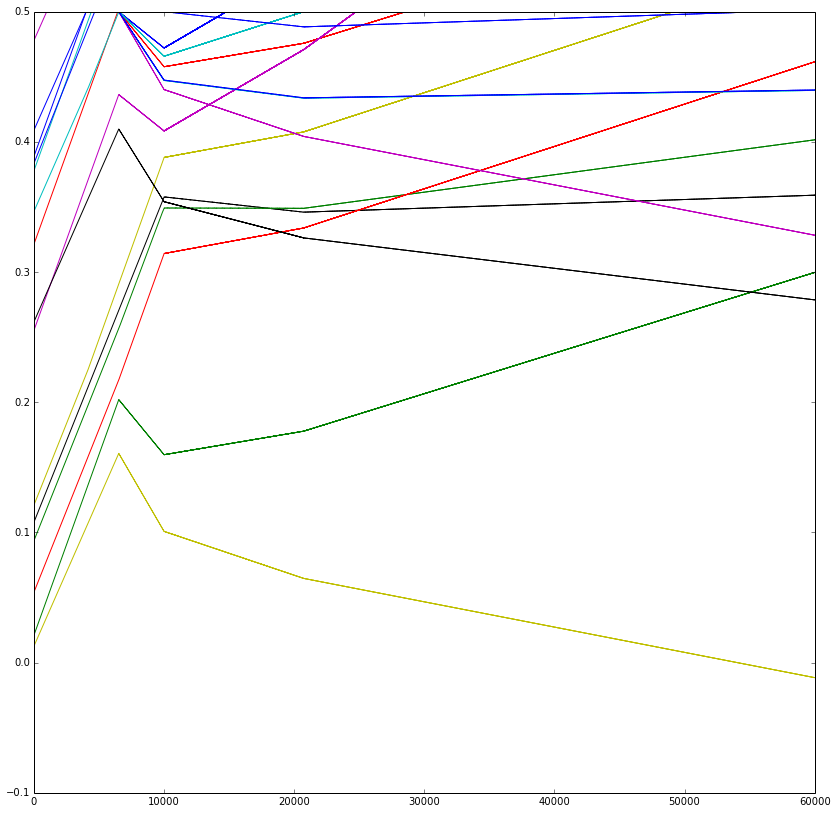

(60000, 15)


In [7]:
w_list = np.array(w_list)
fig = plt.figure(figsize=(14, 14))
plt.plot(w_list[:, :])
plt.show()
print w_list.shape